# Построение модели для определения стоимости автомобиля

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: сервис по продаже автомобилей с пробегом «Не бит, не крашен»**

**Проект заказчика: разработка приложения для привлечения новых клиентов для определения рыночной стоимости своего автомобиля.**

Предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель**

Построить модель для определения стоимости.

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Задачи**

1. Использовать несколько разных моделей, одна из которых — `LightGBM`, как минимум одна — не бустинг. 
2. Сравнить характеристики моделей:
    - скорость работы,
    - точность результата.
3. Для оценки качества моделей применить метрику RMSE.
4. Значение метрики RMSE должно быть < 2500.
5. Количество изменяемых параметров модели градиентного бустинга: 2-3. 

**Описание данных**

- **Признаки:**
    - `DateCrawled` — дата скачивания анкеты из базы
    - `VehicleType` — тип автомобильного кузова
    - `RegistrationYear` — год регистрации автомобиля
    - `Gearbox` — тип коробки передач
    - `Power` — мощность (л. с.)
    - `Model` — модель автомобиля
    - `Kilometer` — пробег (км)
    - `RegistrationMonth` — месяц регистрации автомобиля
    - `FuelType` — тип топлива
    - `Brand` — марка автомобиля
    - `NotRepaired` — была машина в ремонте или нет
    - `DateCreated` — дата создания анкеты
    - `NumberOfPictures` — количество фотографий автомобиля
    - `PostalCode` — почтовый индекс владельца анкеты (пользователя)
    - `LastSeen` — дата последней активности пользователя


- **Целевой признак:**
    - `Price` — цена (евро)

### Импорт библиотек, установка глобальных настроек

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', 100)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='notebook'

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import re

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder 

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, Dataset
import lightgbm as lgb

import time

import shap

import random

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

#### Изучение общей информации о данных

In [4]:
display(df.info(), df.head(), df.describe())

print(f'\n\033[1m\033[4mКоличество явных дубликатов:\033[0m\n\
{df.duplicated().sum()}\n\n\
\033[1m\033[4mПризнаки без пропусков:\033[0m\n\
{pd.Series(df.columns[df.isna().sum()==0])}\n\n\
\033[1m\033[4mИнформация о пропусках (в долях):\033[0m\n\
{df.isna().mean().sort_values(ascending=False)[df.isna().mean()>0].round(3)}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

Price  RegistrationYear      Power  Kilometer  RegistrationMonth  \
count 354369.000        354369.000 354369.000 354369.000         354369.000   
mean    4416.657          2004.234    110.094 128211.173              5.715   
std     4514.159            90.228    189.850  37905.342              3.726   
min        0.000          1000.000      0.000   5000.000              0.000   
25%     1050.000          1999.000     69.000 125000.000              3.000   
50%     2700.000          2003.000    105.000 150000.000              6.000   
75%     6400.000          2008.000    143.000 150000.000              9.000   
max    20000.000          9999.000  20000.000 150000.000             12.000   

       NumberOfPictures  PostalCode  
count        354369.000  354369.000  
mean              0.000   50508.689  
std               0.000   25783.096  
min               0.000    1067.000  
25%               0.000   30165.000  
50%               0.000   49413.000  
75%               0.000   71083.000  
max               0.000   99998.000


Количество явных дубликатов:
4

Признаки без пропусков:
0           DateCrawled
1                 Price
2      RegistrationYear
3                 Power
4             Kilometer
5     RegistrationMonth
6                 Brand
7           DateCreated
8      NumberOfPictures
9            PostalCode
10             LastSeen
dtype: object

Информация о пропусках (в долях):
NotRepaired   0.201
VehicleType   0.106
FuelType      0.093
Gearbox       0.056
Model         0.056
dtype: float64



- наименования столбцов в верблюжем регистре
- присутствуют явные дубликаты
- некоторые столбцы не влияют на целевой признак по смыслу
- в некоторых признаках тип данных не соответствует содержанию
- присутствуют пропуски

#### Сохранение размера исходного датасета

Для проведения дальнейших сравнений сохраним размер исходного датасета в отдельную переменную

In [5]:
len_original = len(df)

#### Приведение наименований столбцов к змеиному регистру

In [6]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

#### Удаление явных дубликатов

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



#### Работа с типами данных и смысловой нагрузкой признаков

##### Создание датафрейма признаков

Запишем типы признаков в отдельный датафрейм.

In [8]:
df_types = pd.DataFrame(df.dtypes).rename(columns={0: 'type'}) 

Запишем пояснения к наименованиям признаков в отдельную переменную.

In [9]:
col_meaning = ['Дата скачивания анкеты из базы',
               'Цена (евро) - таргет',
               'Тип автомобильного кузова',
               'Год регистрации автомобиля',
               'Тип коробки передач',
               'Мощность (л. с.)',
               'Модель автомобиля',
               'Пробег (км)',
               'Месяц регистрации автомобиля',
               'Тип топлива',
               'Марка автомобиля',
               'Была машина в ремонте или нет',
               'Дата создания анкеты',
               'Количество фотографий автомобиля',
               'Почтовый индекс владельца анкеты (пользователя)',
               'Дата последней активности пользователя']

Дополним датафрейм `df_types` ранее созданными пояснениями.

In [10]:
df_types['meaning'] = col_meaning

##### Выделение признаков с датой

Выделим признаки датой.

In [11]:
def highlight_date_types(df):
    if 'Дата' in df['meaning'] or 'Год' in df['meaning'] or 'Месяц' in df['meaning']:
        return ['background-color: lightskyblue'] * len(df)

In [12]:
df_types.style.apply(highlight_date_types, axis=1)

Выделенные признаки с типами данных, несоответствующими содержанию.

##### Признаки с полной датой

Выполним замену типа для столбцов с полной датой.

In [13]:
df[['date_crawled', 'date_created', 'last_seen']] = df[['date_crawled', 'date_created', 'last_seen']].apply(pd.to_datetime)
pd.DataFrame(df[['date_crawled', 'date_created', 'last_seen']].dtypes).rename(columns={0: 'type'})

type
date_crawled  datetime64[ns]
date_created  datetime64[ns]
last_seen     datetime64[ns]

Визуализируем распределения значений в признаках с полной датой на столбчатых диаграммах.

<ins>Год.

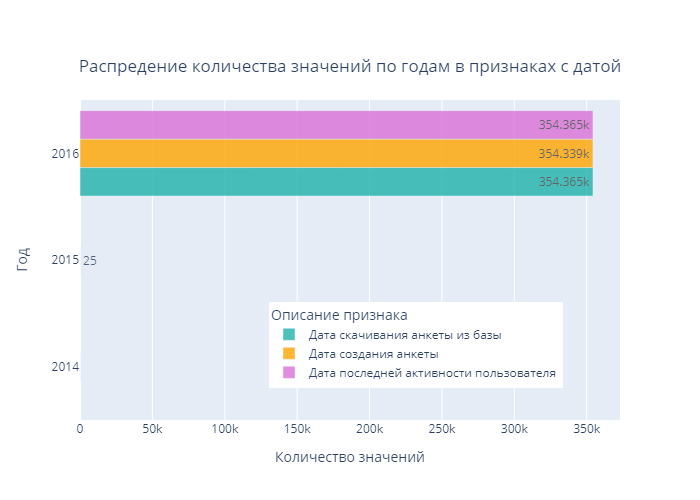

In [14]:
fig = go.Figure(data=[go.Bar(y=df['date_crawled'].dt.year.value_counts().index,
                             x=df['date_crawled'].dt.year.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['date_crawled','meaning'], texttemplate='%{x}',
                             marker=dict(color='lightseagreen')),
                      go.Bar(y=df['date_created'].dt.year.value_counts().index,
                             x=df['date_created'].dt.year.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['date_created','meaning'], texttemplate='%{x}',
                             marker=dict(color='orange')),
                      go.Bar(y=df['last_seen'].dt.year.value_counts().index,
                             x=df['last_seen'].dt.year.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['last_seen','meaning'], texttemplate='%{x}',
                             marker=dict(color='orchid'))])

fig.update_layout(title={'text': 'Распредение количества значений по годам в признаках с датой',
                         'y':0.88,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  xaxis_title='Количество значений',
                  yaxis_title='Год',
                  legend_title='Описание признака',
                  legend=dict(yanchor='top', y=.37, xanchor='left', x=.35))

fig.update_yaxes(dtick=1)

fig.show('png')

- большинство значений в 2016 году

<ins>Месяц.

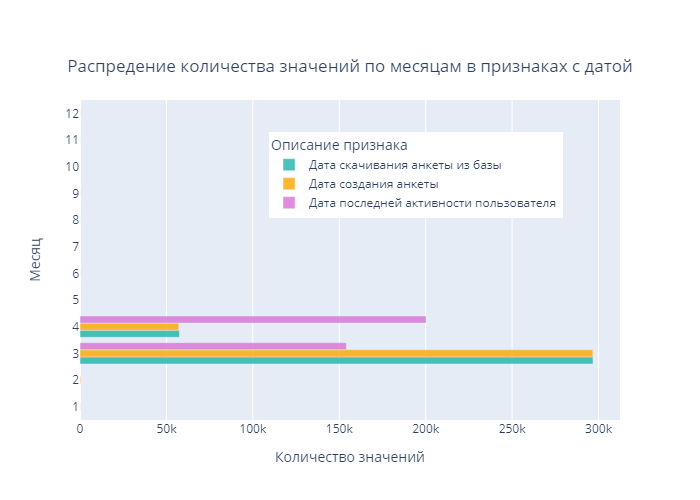

In [15]:
fig = go.Figure(data=[go.Bar(y=df['date_crawled'].dt.month.value_counts().index,
                             x=df['date_crawled'].dt.month.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['date_crawled','meaning'],
                             marker=dict(color='lightseagreen')),
                      go.Bar(y=df['date_created'].dt.month.value_counts().index,
                             x=df['date_created'].dt.month.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['date_created','meaning'],
                             marker=dict(color='orange')),
                      go.Bar(y=df['last_seen'].dt.month.value_counts().index,
                             x=df['last_seen'].dt.month.value_counts(),
                             opacity=0.8, orientation='h',
                             name=df_types.loc['last_seen','meaning'],
                             marker=dict(color='orchid'))])

fig.update_layout(title={'text': 'Распредение количества значений по месяцам в признаках с датой',
                         'y':0.88,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  xaxis_title='Количество значений',
                  yaxis_title='Месяц',
                  legend_title='Описание признака',
                  legend=dict(yanchor='top', y=.9, xanchor='left', x=.35))

fig.update_yaxes(dtick=1)

fig.show('png')

- большинство значений в 3-ем и 4-ом месяцах

Смысловая нагрузка данных признаков в условиях текущей задачи под вопросом. Окончательное решение по их удалению примем позже.

##### Месяц регистрации автомобиля

Визуализируем количество значений по каждому месяцу регистрации на столбчатой диаграмме.

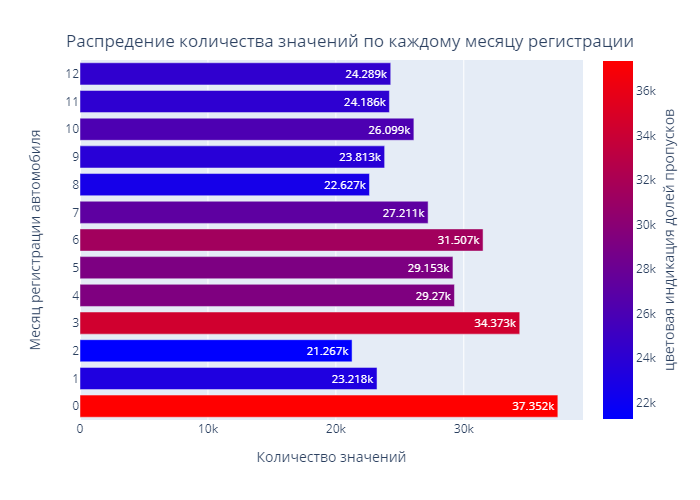

In [16]:
fig = px.bar(y=df['registration_month'].value_counts().index,
             x=df['registration_month'].value_counts(),
             orientation='h',
             text_auto=True,
             color=df['registration_month'].value_counts())

fig.update_layout(title={'text': 'Распредение количества значений по каждому месяцу регистрации',
                         'y':0.93,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  coloraxis = dict(colorscale='Bluered'),
                  
                  coloraxis_colorbar=dict(title = dict(text='цветовая индикация долей пропусков', side='right'),
                                          len=1.05),
                  
                  xaxis_title='Количество значений',
                  yaxis_title=df_types.loc['registration_month','meaning'])

fig.update_yaxes(dtick=1)

fig.show('png')

- Месяца с номером `0` не существует. В датафрейме максимальное количество значений для месяца с номером ноль. Логически месяц регистрации может влиять на результат машинного обучения, признак нужно оставить.
- Перевод в тип `datetime` невозможен из-за нулевого значения месяца, тип оставим без изменений.
- Значение месяца `0` - единственное аномальное в данном признаке, также оставим его без изменений, будем считать, что оно означает `месяц не задан`.
- На результат машинного обучения при применении нелинейных моделей решения, описанные выше, не повлияют.
- При применении линейных моделей для более точного определения весов необходимо добавить дополнительный признак с `флагом`:
    - `0` - при корректных значениях признака
    - `1` - при аномальных значениях признака

##### Год регистрации автомобиля

Построим интерактивный график (применяется масштабирование), включающий гистограмму и диаграмму размаха распределения значений по году регистрации автомобиля.

In [17]:
def hist_box (df: pd.DataFrame, name: 'column_name'):
    fig = px.histogram(df, x=name, marginal='box')
    
    fig.update_layout(title={'text': f'Распредение количества значений по признаку "{name}"',
                             'y':0.93,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      xaxis_title=df_types.loc[name,'meaning'],
                      yaxis_title='Количество значений')
    
    fig.show('png')

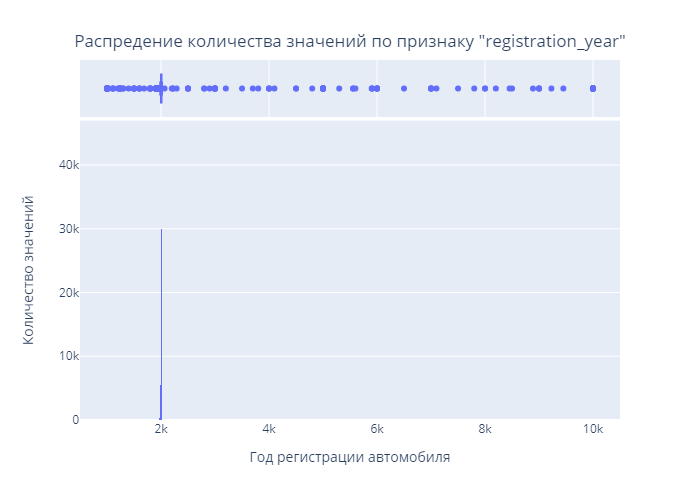

In [18]:
hist_box (df, 'registration_year')

- в датасете выявлены аномальные значения в признаке `registration_year`
- масштабированием графика определили основной разброс значений в диапазоне с 1985 по 2019 год
- пик - начало 2000-х

- Год регистрации безусловно должен быть важным показателем при определении цены автомобиля.
- Из анализа признаков с полной датой видно, что год скачивания анкеты из базы 2016, значения выше - аномалии.
- Минимальный порог нормальных значений примем по минимуму диаграммы размаха с небольшим запасом - 1977 (дадим возможность модели поработать с ретро автомобилями), ниже - аномалии.

Выполним замену аномальных значений на `0` чтобы не вводить модель в заблуждение, т.к. по смыслу (далее будем проводить программную проверку) год регистрации один из основных признаков, влияющих на цену.

In [19]:
df.loc[(df['registration_year'] < 1977) | (df['registration_year'] > 2016), 'registration_year'] = 0

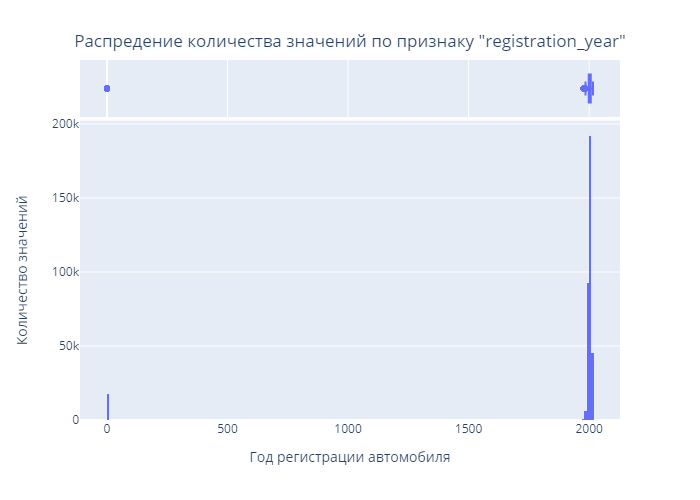

In [20]:
hist_box (df, 'registration_year')

Замена выполнена успешно.

- Теперь значение года `0` - единственное аномальное в данном признаке, будем считать, что оно означает `год не задан`.
- На результат машинного обучения при применении нелинейных моделей оно не повлияют.
- При применении линейных моделей для более точного определения весов необходимо добавить дополнительный признак с `флагом`:
    - `0` - при корректных значениях признака
    - `1` - при аномальных значениях признака

##### Почтовый индекс владельца анкеты (пользователя)

In [21]:
df_types.style.apply(lambda x: ['background: lightskyblue' if x.name in 'postal_code' else '' for i in x], axis=1)

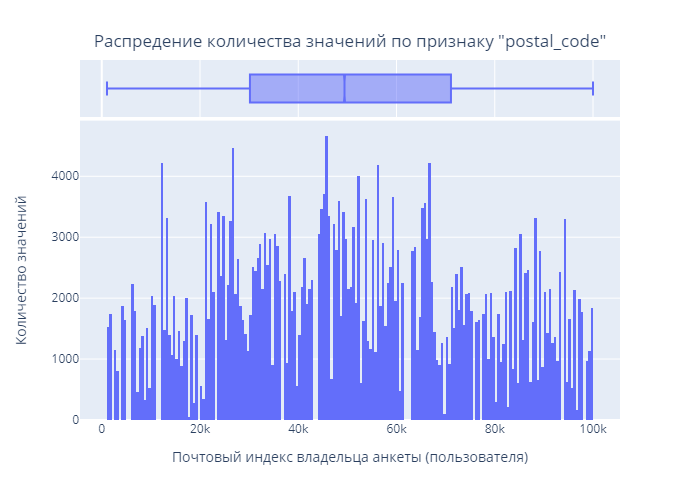

In [22]:
hist_box (df, 'postal_code')

- Индекс, определяющий регион продажи, по смыслу должен влиять на цену авто:
https://www.drive2.ru/b/493917391823044674/
- Разброс значений велик, форма ближе к "гребенке", закономерности не наблюдается.
- Решение о необходимости данного признака примем позже.

##### Количество фотографий автомобиля

In [23]:
df_types.style.apply(lambda x: ['background: lightskyblue' if x.name in 'number_of_pictures' else '' for i in x], axis=1)

Данный признак для дальнейнейшей работы не нужен, т.к. не несёт никакой смысловой нагрузки в условиях текущей задачи. Удалим.

In [24]:
df = df.drop(columns='number_of_pictures')

Проверим на наличие явных дубликатов после удаления признака.

In [25]:
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



#### Работа с пропусками

Сохраним доли пропусков в отдельную переменную.

In [26]:
df_nan = df.isna().mean().sort_values(ascending=False)[df.isna().mean()>0]

Визуализируем доли пропусков на столбчатой диаграмме.

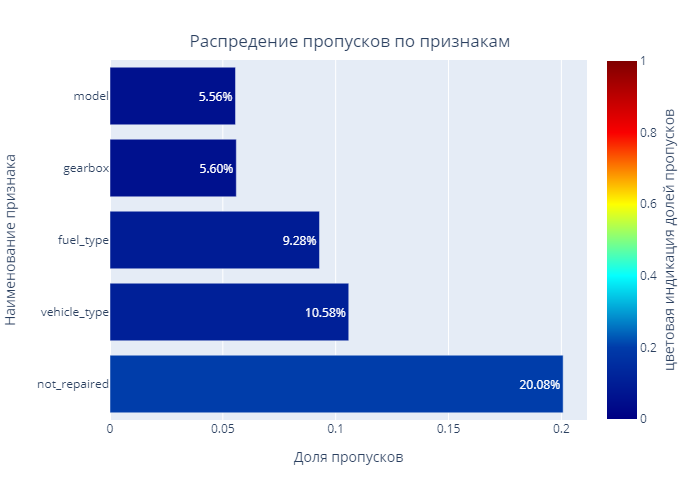

In [27]:
fig = px.bar(y=df_nan.index,
             x=df_nan,
             orientation='h',
             text_auto='.2%',
             color=df_nan)

fig.update_traces(textangle=0)

fig.update_layout(title={'text': 'Распредение пропусков по признакам',
                         'y':0.93,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  coloraxis = dict(colorscale='Jet', cmin=0, cmax=1),
                  
                  coloraxis_colorbar=dict(title = dict(text='цветовая индикация долей пропусков', side='right'),
                                          len=1.05),
                  
                  xaxis_title='Доля пропусков',
                  yaxis_title='Наименование признака')

fig.show('png')

In [28]:
df_types.style.apply(lambda x: ['background: lightskyblue' if x.name in df_nan.index else '' for i in x], axis=1)

- Пропусков значительное количество.
- Пропуски в категориальных признаках.

Т.к. модели алгоритмы моделей машинного обучения не предусматривают заполнение пропусков для категориальных признаков, а при наличии пропусков работать не будут, заменим пропуски значением `no_info`.

In [29]:
df[df_nan.index]=df[df_nan.index].fillna('no_info')
print(f'\033[1mКоличество пропусков в датасете: {df.isna().sum().sum()}')

Количество пропусков в датасете: 0


Проверим на наличие явных дубликатов после удаления признака.

In [30]:
print(f'\033[1mКоличество явных дубликатов в датасете: {df.duplicated().sum()}\n')

Количество явных дубликатов в датасете: 0



## Исследовательский анализ данных (EDA)

### Анализ распределения данных 

#### Целевой признак

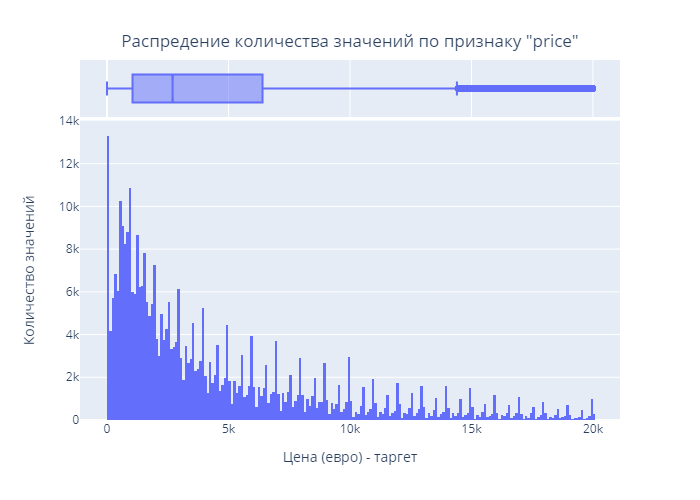

In [31]:
hist_box (df, 'price')

- гистограмма с аномально высоким краем
- довольно много значений, выходящих за пределы максимума диаграммы размаха
- подобные наблюдения могут отрицательно сказать на машинном обучении

Цены ниже 100 евро очевидная аномалия, отфильтруем датафрейм от данных значений.

In [32]:
df = df.query('price>100')

In [33]:
print(f'процент удаленных данных относительно исходного датасета: {1-len(df)/len_original:.2%}')

процент удаленных данных относительно исходного датасета: 4.05%


#### Тип автомобильного кузова

In [34]:
def hist_cat (df: pd.DataFrame, name: 'column_name'):
    fig = px.histogram(df, x=name, text_auto=True)
    
    fig.update_layout(title={'text': f'Распредение количества значений по признаку "{name}"',
                             'y':0.93,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      xaxis_title=df_types.loc[name,'meaning'],
                      yaxis_title='Количество значений')
    
    fig.show('png')

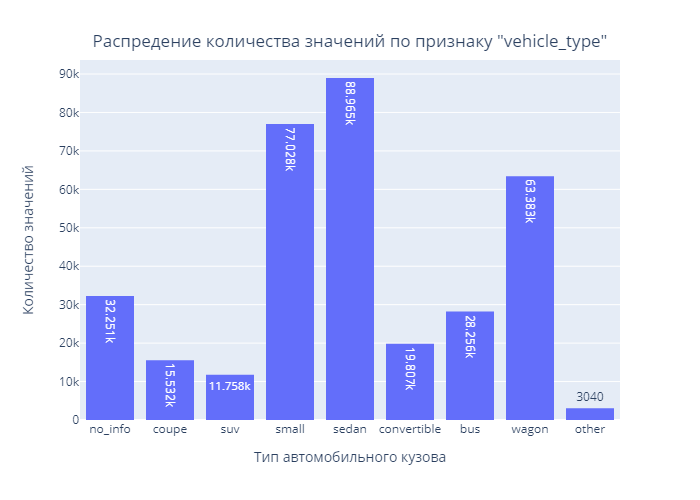

In [35]:
hist_cat (df, 'vehicle_type')

- Большинство автомобилей с типом кузова `small` и `sedan`, на третьем месте `wagon`, остальных значительно меньше.

#### Год регистрации автомобиля

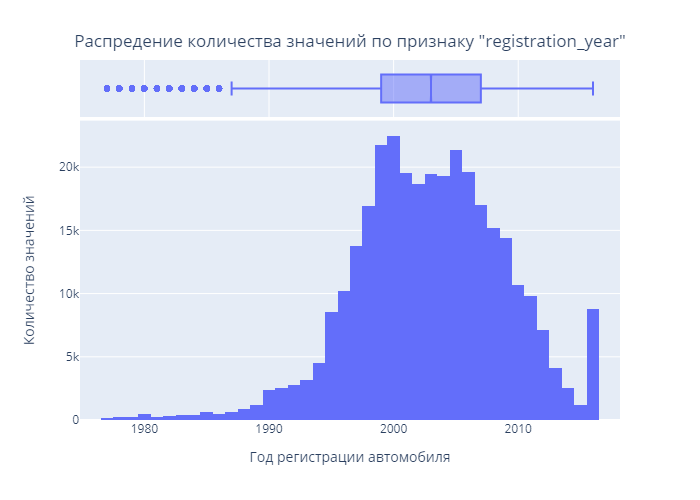

In [36]:
hist_box (df.query('registration_year>0'), 'registration_year')

- Не считая аномальные значения, которые ранее были заменены на `0`, данные смещены влево, имеется дополнительный пик в 2016 году.

#### Тип коробки передач

In [37]:
def pie_cat (df: pd.DataFrame, name: 'column_name'):    
    fig = go.Figure(data=[go.Pie(labels=df[name].value_counts().index, values=df[name].value_counts())])
    
    fig.update_layout(title={'text': f'Процент категорий в признаке "{name}"',
                             'y':0.88,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      legend_title=df_types.loc[name,'meaning'],
                      legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.7))
    
    fig.show('png')

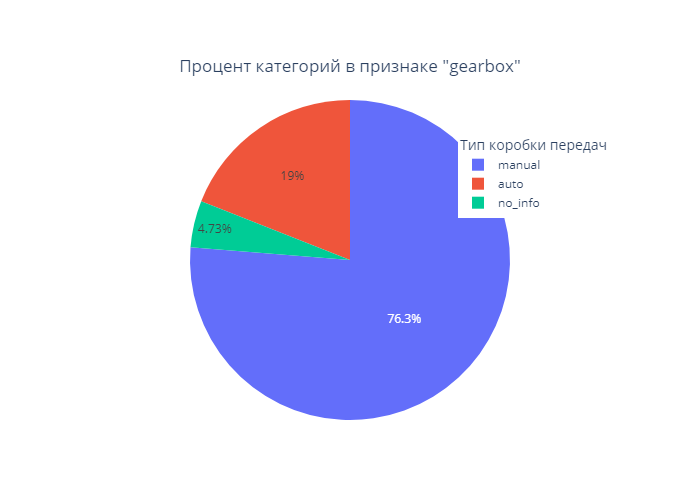

In [38]:
pie_cat (df, 'gearbox')

- большинство автомобилей с ручной коробкой передач

#### Мощность

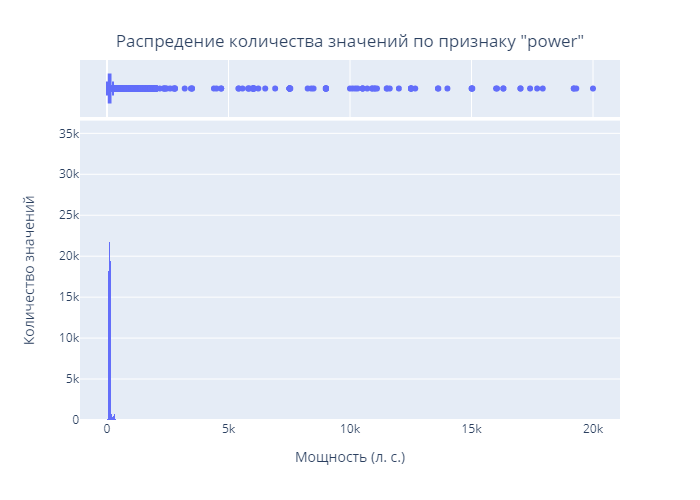

In [39]:
hist_box (df, 'power')

- в датасете выявлены аномальные значения в признаке `power`
- масштабированием графика определили основной разброс значений в диапазоне от 0 по 255 л.с.
- пик в `нуле` - явная аномалия
- распределение со смещением вправо

- Мощность безусловно должна быть важным показателем при определении цены автомобиля.
- Самые мощные автомобили в мире по ссылке:<br>
https://zen.yandex.ru/media/auto_now/10-avto-s-samym-bolshim-kolvom-loshadinyh-sil-5b7c3fe9c88f9700a9bb6209
- Учитывая цену автомобилей по ссылке выше в нашем датасете нет.
- Верхний порог нормальных значений примем по по максимуму диаграммы размаха с небольшим запасом - 300 (дадим возможность модели поработать с мощными автомобилями), выше - аномалии.
- Нижний порог нормальных значений примем выше `0`.

Выполним замену аномальных значений на `0` чтобы не вводить модель в заблуждение, т.к. по смыслу (далее будем проводить программную проверку) мощность - важный признак, влияющий на цену.

In [40]:
df.loc[(df['power'] <= 0) | (df['power'] > 300), 'power'] = 0

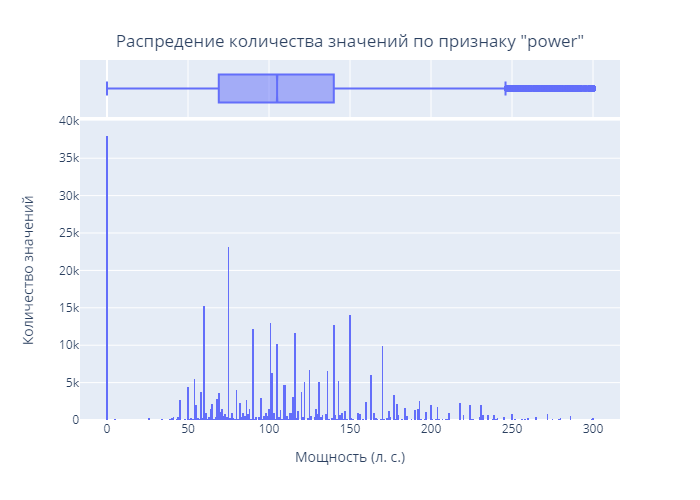

In [41]:
hist_box (df, 'power')

Замена выполнена успешно.

- Теперь значение мощности `0` - единственное аномальное в данном признаке, будем считать, что оно означает `мощность не задана`.
- На результат машинного обучения при применении нелинейных моделей оно не повлияют.
- При применении линейных моделей для более точного определения весов необходимо добавить дополнительный признак с `флагом`:
    - `0` - при корректных значениях признак
    - `1` - при аномальных значениях признака

#### Модель автомобиля

In [42]:
auto_model_count = np.concatenate((df['model'].value_counts().values, np.zeros(5).astype('int'))).reshape((16, 16))

In [43]:
auto_model_index = np.concatenate((df['model'].value_counts().index.values, ['no_model']*5)).reshape((16, 16))

In [44]:
def heat_cat (z: 'cell_values', z_text: 'cell names', name: 'column_name', width, height, t_size):    
    
    fig = px.imshow(z, color_continuous_scale='Blues', aspect="auto")
    fig.update_traces(text=z_text, texttemplate="%{text}", textfont_size=t_size)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    
    fig.update_layout(title={'text': f'Тепловая карта распредения значений по признаку "{name}"',
                             'y':0.97,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      width=width,
                      height=height,
                      
                      coloraxis_colorbar=dict(title = dict(text='Количество значений', side='right'),
                                              x=1.0,
                                              len=1.05,
                                              thickness=15)
                      )
    
    fig.show('png')

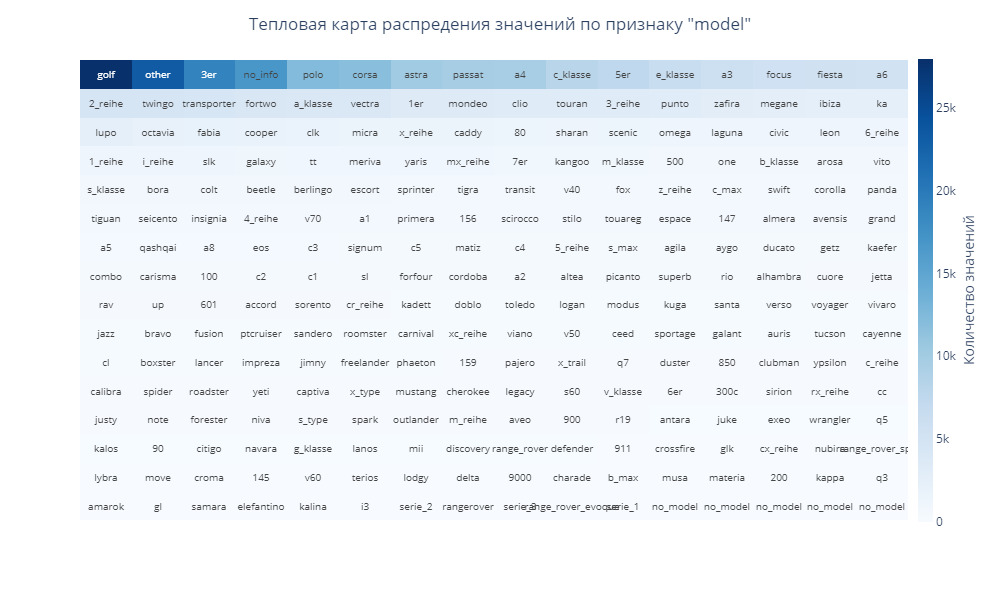

In [45]:
heat_cat (auto_model_count, auto_model_index, 'model', width=1000, height=600, t_size=10)

- Признак категориальный, количество категорий - 251.
- Большинство значений в датасете у первых 3-х моделей, также значительное количество без указания модели (`no_info`).
- Данный признак должен влиять на таргет по смыслу.
- Для модели `CatBoost` допустимо оставить значения данного признака без изменений, т.к. `CatBoost` самостоятельно преобразовывает категориальные признаки.
- Для линейных и нелинейных моделей необходимо применять разные техники преобразования и кодирования.
- Решение о его использовании примем позже.

Проверим на неявные дубликаты.

In [46]:
auto_model_unique = np.concatenate((sorted(df['model'].unique()), ['no_model']*1)).reshape((21, 12))

In [47]:
pd.DataFrame(auto_model_unique).style.applymap(lambda x: 'background-color: lightskyblue'
                                               if x=='range_rover' or x=='rangerover'
                                               else '')

Выполним замену неявных дубликатов.

In [48]:
df['model'] = df['model'].replace('rangerover', 'range_rover')

После замены проверим на явные дубликаты

In [49]:
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



#### Пробег

In [50]:
def bar_num_h (df: pd.DataFrame, name: 'column_name', texttemplate: str, width):    
    fig = go.Figure(data=[go.Bar(y=df[name].value_counts().index,
                                 x=df[name].value_counts(),
                                 texttemplate=texttemplate,
                                 textangle=0,
                                 textposition='auto',
                                 orientation='h',
                                 width=width
                                )])
    
    fig.update_layout(title={'text': f'Распредение количества значений по признаку "{name}"',
                             'y':0.92,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      yaxis_title=df_types.loc[name,'meaning'],
                      xaxis_title='Количество значений',
                      
                      width=1000,
                      height=800)
    
    
    fig.show('png')

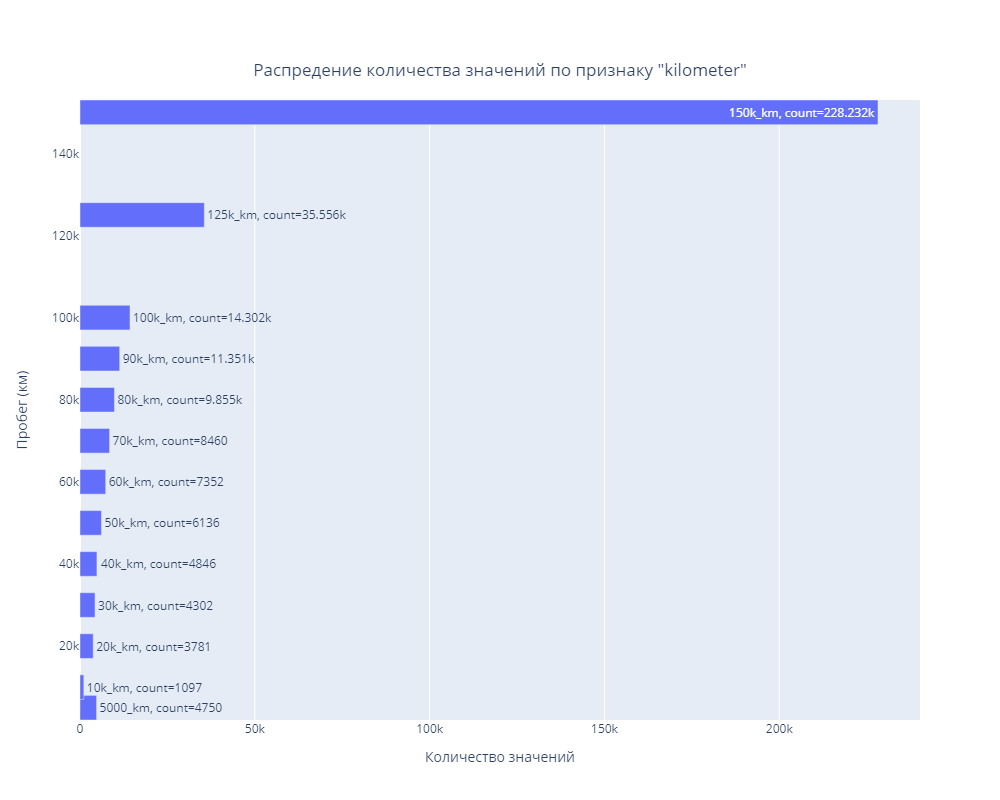

In [51]:
bar_num_h(df, 'kilometer', '%{y}_km, count=%{x}', 6000)

- количество автомобилей в датасете растет с увеличением пробега
- основная масса автомобилей с пробегом более 100 тыс. км

#### Тип топлива

In [52]:
def bar_cat_h (df: pd.DataFrame, name: 'column_name'):
    fig = go.Figure(data=[go.Bar(y=df[name].value_counts().sort_values().index,
                             x=df[name].value_counts().sort_values(),
                             texttemplate='count=%{x}',
                             textangle=0,
                             textposition='auto',
                             orientation='h'
                            )])

    fig.update_layout(title={'text': f'Распредение количества значений по признаку "{name}"',
                             'y':0.87,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      yaxis_title=df_types.loc[name,'meaning'],
                      xaxis_title='Количество значений')   
    
    fig.show('png')

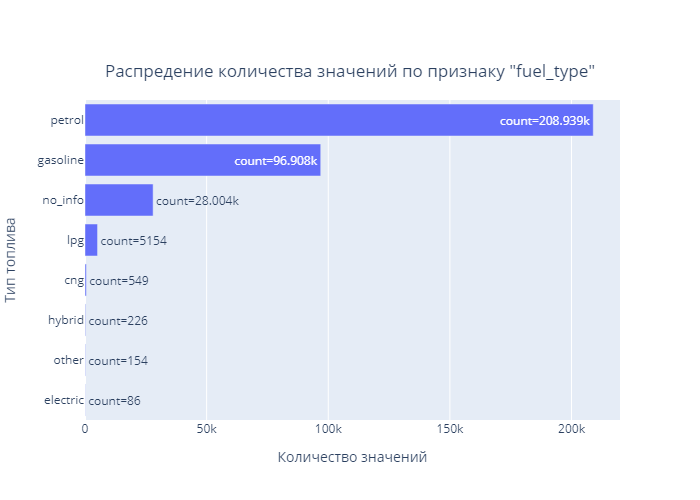

In [53]:
bar_cat_h (df, 'fuel_type')

- `petrol` и `gasoline` синонимы - бензин
- `lpg` - сжиженный пропан
- `cng` - сжатый метан
- `hybrid` - модели с бензиновым и электрическим двигателями
- `electric` - модели с электрическим двигателем
- странно, что нет дизельного топлива, возможно, попало в категорию `other`, но там довольно мало значений
- напрашивается вариант объединить `petrol` и `gasoline`, но так как нет топлива типа `diesel` не будем этого делать, т.к. возможно оно попало в одну из этих категорий

#### Марка автомобиля

In [54]:
auto_brand_count = df['brand'].value_counts().values.reshape((5, 8))

In [55]:
auto_brand_index = df['brand'].value_counts().index.values.reshape((5, 8))

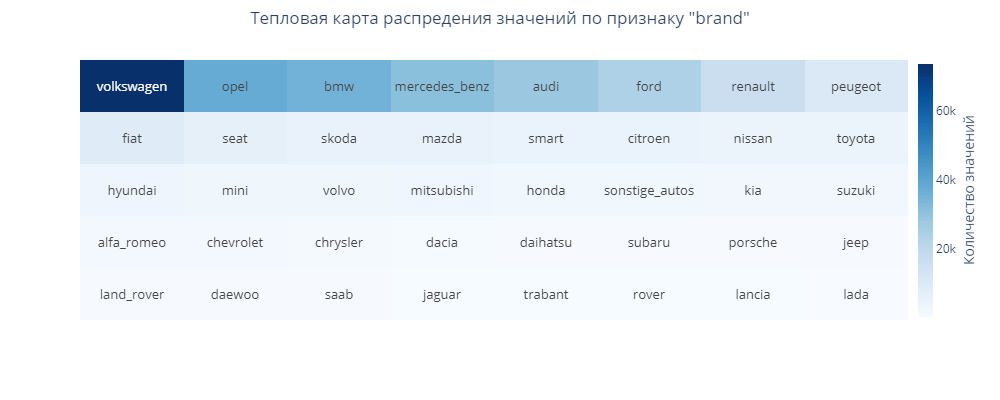

In [56]:
heat_cat (auto_brand_count, auto_brand_index, 'brand', width=1000, height=400, t_size=13)

- первые 7 брендов имеют ощутимое преимущество над остальными по количеству автомобилей в датасете:

In [57]:
list(df['brand'].value_counts().sort_values(ascending=False).head(7).index)

['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault']

#### Была машина в ремонте или нет

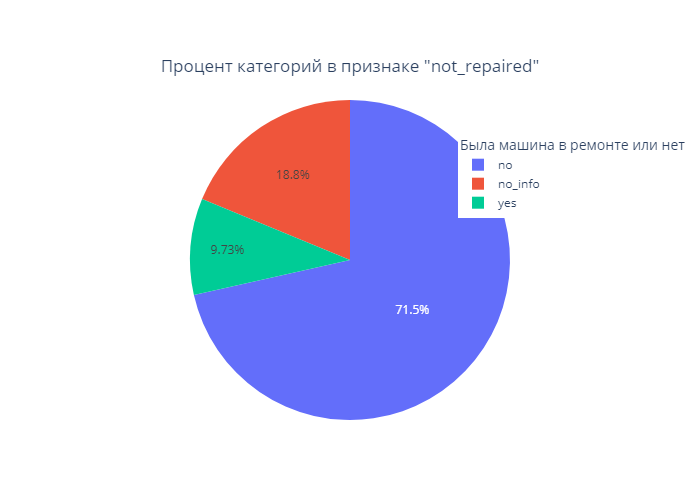

In [58]:
pie_cat (df, 'not_repaired')

- основная масса автомобилей датасета в ремонте не была

Остальные переменные были исследованы ранее.

### Матрица рассеяния между признаками

#### Матрица рассеяния между количественными признаками без аномальных значений

Сохраним количественные признаки без аномальных значений вместе с таргетом в отдельную переменную.

In [59]:
df_smatrix_num = df[['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']]
df_smatrix_num = df_smatrix_num.query('registration_year>0 and registration_month>0 and power>0')

Построим матрицу рассеяния.

In [60]:
def num_s_matrix (df: pd.DataFrame, color: str):    
    fig = px.scatter_matrix(df, opacity=0.01,
                            color=color,
                            color_continuous_scale='Bluered')
    
    fig.update_layout(title={'text': 'Матрица рассеяния между признаками',
                             'y':0.97,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      width=1000,
                      height=1000,                  
                      coloraxis_colorbar=dict(x=1.01,                                        
                                              len=1.02,
                                              thickness=15,
                                              title = dict(text='Цена (евро)', side='right'))
                     )
          
    fig.show('png')

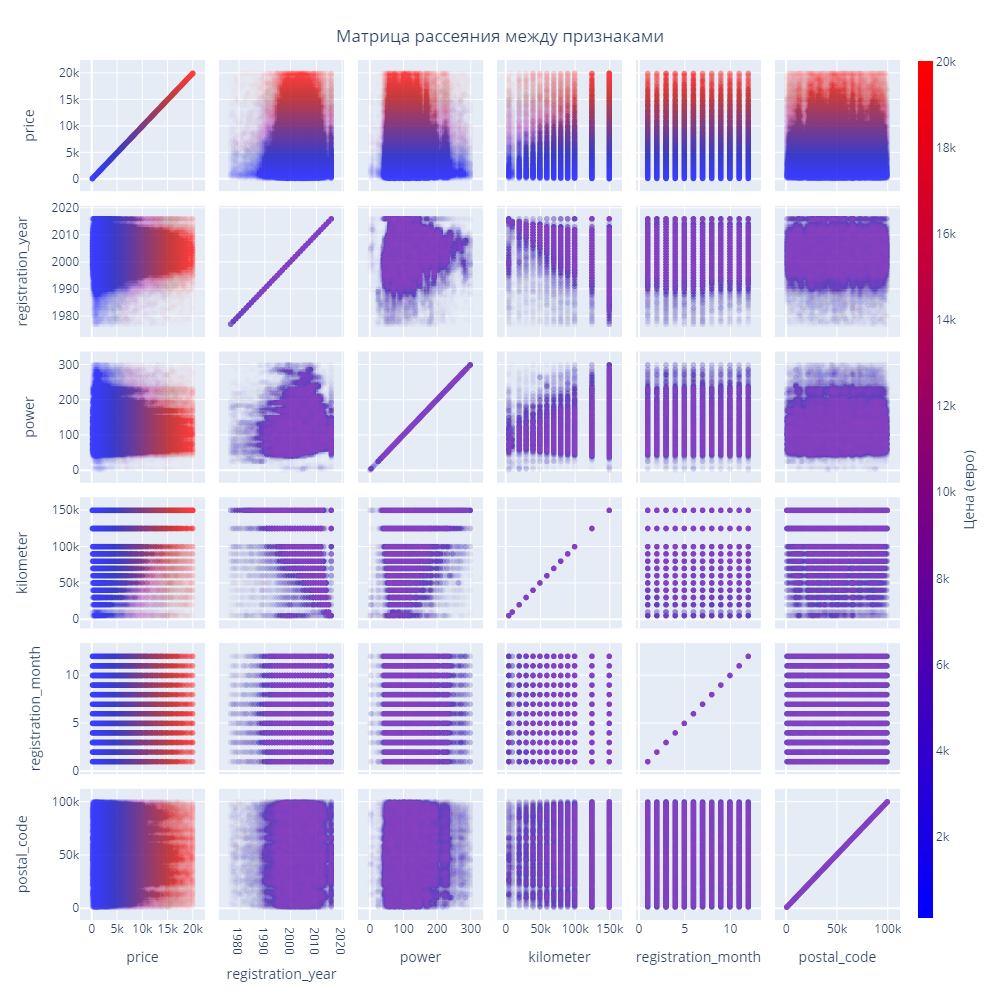

In [61]:
num_s_matrix (df_smatrix_num, 'price')

- чем больше пробег, тем больше цена (это странно, визуальной оценки не достаточно, далее посмотрим взаимосвязи вычисленные программно)
- чем моложе авто (больше значение года регистрации), тем меньше пробег
- небольшая зависимость пробега от мощности - с большим пробегом автомобили с большей мощностью
- небольшая зависимость возраста авто (год регистрации) от мощности - чем моложе авто, тем больше мощность
- влияние почтового индекса на таргет минимально

In [62]:
print(f'Количество уникальных значений в признаке "postal_code": {len(df["postal_code"].unique())}')

Количество уникальных значений в признаке "postal_code": 8137


Принятие решения по удалению признака `postal_code`:
1. по исходным данным требует важно сминимизировать время обучения модели,
2. влияние почтового индекса на таргет незначительно,
3. это категориальный признак с цифровой кодировкой,
4. уникальных значений в данном признаке довольно много, что повлияет на время обучения, а, возможно, и на качество.

В контексте данной задачи признак `postal_code` необходимо удалить.

In [63]:
df = df.drop(columns='postal_code')

Проверим на наличие явных дубликатов после удаления признака.

In [64]:
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 1



Удалим явные дубликаты

In [65]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



#### Матрица рассеяния между признаками с датой

Сохраним признаки с датой вместе с таргетом в отдельную переменную.

In [66]:
df_smatrix_date = df[['price','date_crawled', 'date_created', 'last_seen']]

Построим матрицу рассеяния.

In [67]:
def date_s_matrix (df: pd.DataFrame):    
    fig = px.scatter_matrix(df, opacity=0.01)
    
    fig.update_layout(title={'text': 'Матрица рассеяния между признаками',
                             'y':0.97,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      width=800,
                      height=800)
          
    fig.show('png')

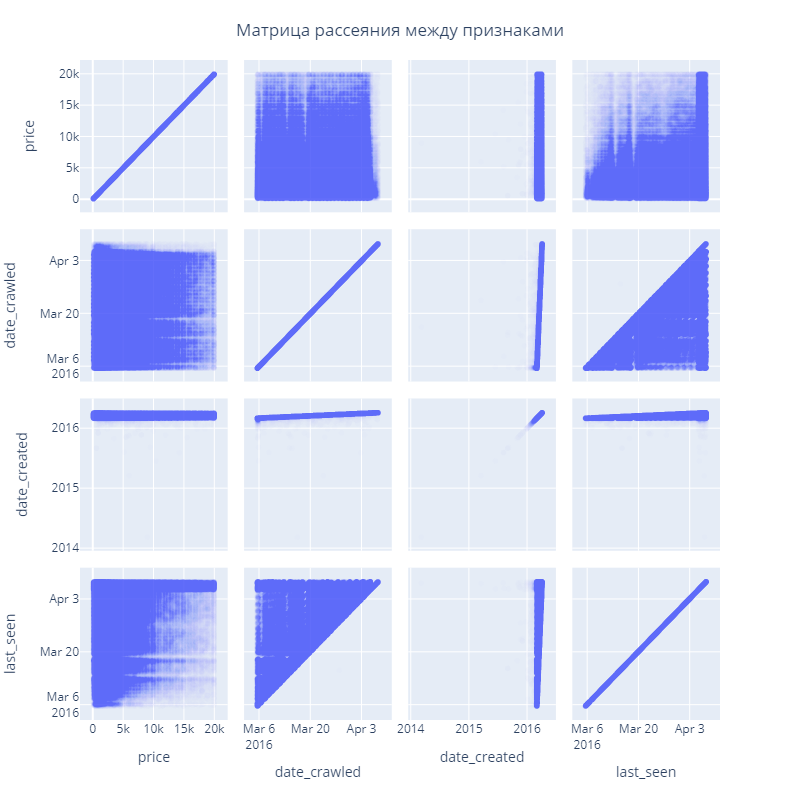

In [68]:
date_s_matrix (df_smatrix_date)

- между признаками с датой есть взаимосвязи, но они бессмысленные, т.к. дата создания анкеты не может влиять на дату скачивания и дату последней активности пользователя
- влияние на таргет незначительное, сильнее всего влияет дата последней активности пользователя - признак `last_seen`, но смысловой нагрузки в этом нет

Удалим данные признаки.

In [69]:
df = df.drop(columns=['date_crawled', 'date_created', 'last_seen'])

Проверим на наличие явных дубликатов после удаления признака.

In [70]:
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 25999



Удалим явные дубликаты

In [71]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



In [72]:
print(f'процент удаленных данных относительно исходного датасета: {1-len(df)/len_original:.2%}')

процент удаленных данных относительно исходного датасета: 11.39%


### Исследование зависимостей между признаками

#### Phik

Более корректно исследовать зависимости в данных по коэффициенту `phik`, т.к. он учитывает и нелинейные взаимосвязи в данных, в отличии от `корреляции Пирсона`.

Создадим новый датафрейм признаков с учетом удаления признаков на предыдущих шагах.

In [73]:
df_types_clean = df_types.loc[df.columns]

Добавим в созданный датафрейм столбец `bin_types` с указанием типов переменных для расчёта взаимосвязей.

In [74]:
df_types_clean['bin_types'] = ['interval',
                              'categorical',
                              'interval',
                              'categorical',
                              'interval',
                              'categorical',
                              'interval',
                              'interval',
                              'categorical',
                              'categorical',
                              'categorical']

In [75]:
df_types_clean

type                        meaning    bin_types
price                int64           Цена (евро) - таргет     interval
vehicle_type        object      Тип автомобильного кузова  categorical
registration_year    int64     Год регистрации автомобиля     interval
gearbox             object            Тип коробки передач  categorical
power                int64               Мощность (л. с.)     interval
model               object              Модель автомобиля  categorical
kilometer            int64                    Пробег (км)     interval
registration_month   int64   Месяц регистрации автомобиля     interval
fuel_type           object                    Тип топлива  categorical
brand               object               Марка автомобиля  categorical
not_repaired        object  Была машина в ремонте или нет  categorical

Т.к. для дальнейшего вычисления коэффициента `phik` переменные типа `interval` необходимо группировать, создадим список данных переменных, который в дальнейшем передадим в качестве параметра в `phik_matrix`.

In [76]:
interval_cols = df_types_clean.query('bin_types=="interval"').index

Сохраним матрицу зависимостей по значениям коэффициента phik в отдельную переменную.

In [77]:
phik_overview = df.phik_matrix(interval_cols=interval_cols)

Построим тепловую карту взаимосвязей

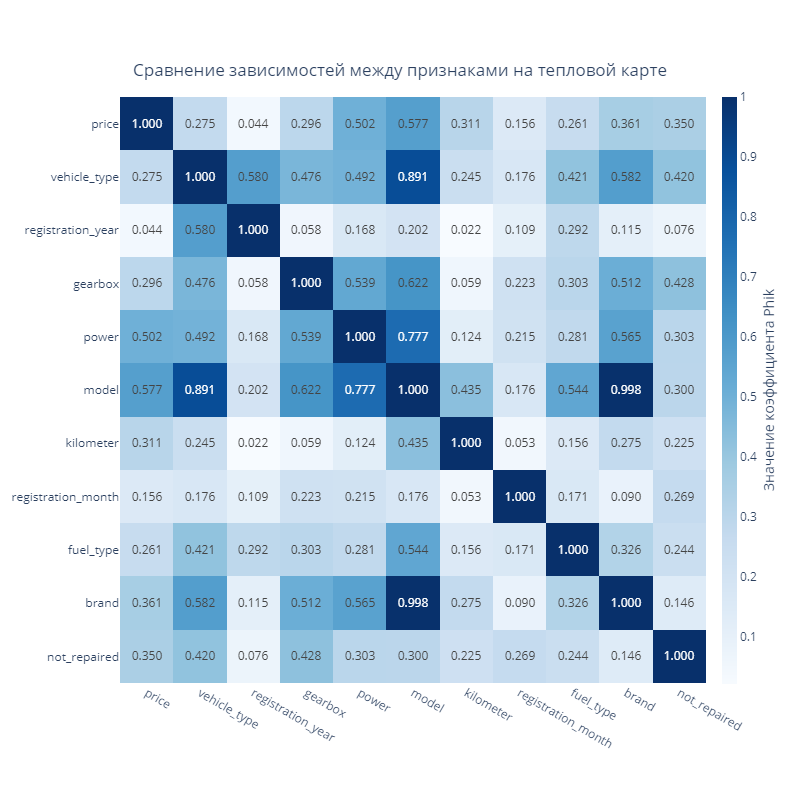

In [78]:
fig = px.imshow(phik_overview, text_auto='.3f')

fig.update_layout(title={'text': 'Сравнение зависимостей между признаками на тепловой карте',
                         'y':0.92,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},                
 
                  coloraxis = dict(colorscale='Blues'),
                  coloraxis_colorbar=dict(x=1.01,
                                          len=0.92,
                                          thickness=15,
                                          title = dict(text='Значение коэффициента Phik', side='right')),
                  width=800,
                  height=800
                 )

fig.show('png')

Сильные зависимости между:
- моделью и брендом
- моделью и типом кузова

Наблюдения
- самые значимые для таргета признаки - модель и мощность
- год регистрации почти не влияет на цену (это очень странно, можно списать только на то, что проект учебный)

#### Дендрограмма схожести признаков

- На основании вычисленных ранее коэффициентов `phik` построим дендрограмму схожести признаков.
- Чем раньше (ниже на дереве) происходит слияние ветвей, тем больше зависимость между признаками (группами признаков).
- Признаки (группы признаков), которые сливаются позже (возле верхушки дерева), имеют меньшую взаимосвязь.

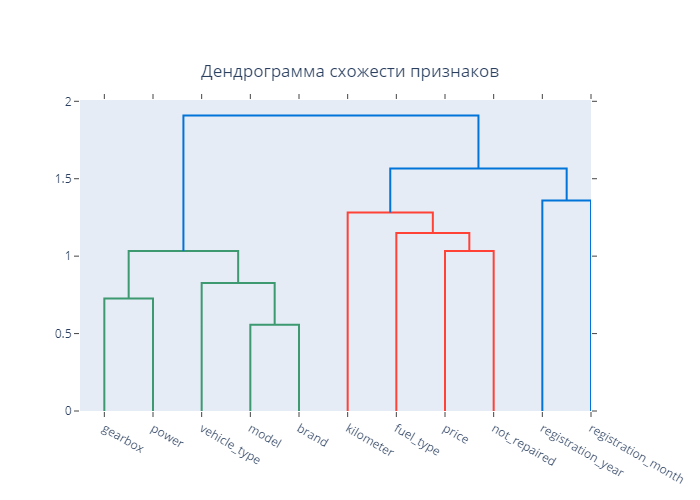

In [79]:
fig = ff.create_dendrogram(phik_overview, labels=phik_overview.index)

fig.update_layout(title={'text': 'Дендрограмма схожести признаков',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show('png')

- Разрезы дендрограммы по горизонтали для определения количества необходимых признаков делать не будем, это тема отдельной работы.

#### Корреляция Пирсона

Для оценки линейных взаимосвязей (как положительных, так и отрицательных) дополнительно вычислим корреляцию Пирсона.

Сохраним матрицу зависимостей по значениям коэффициента phik в отдельную переменную.

In [80]:
correlation = df.corr()

Сравним взаимосвязи между количественными переменными, вычисленные при помощи `Корреляции Пирсона` и `Коэффициента Phik`.

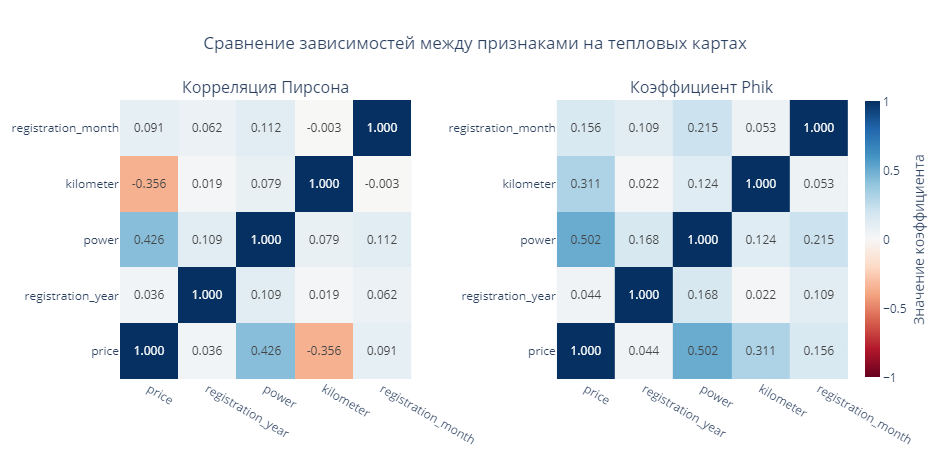

In [81]:
fig = make_subplots(rows=1, cols=2, subplot_titles = ['Корреляция Пирсона', 'Коэффициент Phik'], horizontal_spacing = 0.2)
for f, rel, i  in zip(['fig1', 'fig2'],
                      [correlation, phik_overview.loc[correlation.index, correlation.columns]],
                      [1, 2]):

    locals()[f] = px.imshow(rel, text_auto='.3f') 

    fig.add_trace(locals()[f]['data'][0], row=1, col=i)

fig.update_layout(title={'text': 'Сравнение зависимостей между признаками на тепловых картах',
                         'y':0.92,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},                
 
                  coloraxis = dict(colorscale='RdBu', cmid=0),
                  
                  coloraxis_colorbar=dict(x=1.01,
                                          len=1.06,
                                          thickness=15,
                                          title = dict(text='Значение коэффициента', side='right')),
                  
                  width=950,
                  height=460
                  
                 )    
fig.show('png')

- при сравнении заметна разница между корреляцией Пирсона и Phik, т.к. взаимосвязи отличны от линейных
- предположение о том, что взаимосвязь между годом и ценой отрицательная, сделанное на основании анализа матрицы рассеяния, не подтвердилось
- чем больше мощность, тем больше цена
- чем меньше пробег, тем больше цена
- год и месяц регистрации незначительно влияют на цену
- линейные взаимосвязи признаков между собой ниже средних, что должно положительно сказаться на качестве модели

## Машинное обучение (ML)

### Функция для вычисления метрики RMSE

По исходным данным для оценки качества моделей требуется вычислить метрику `RMSE`, значение `RMSE` должно быть меньше `2500`.

`RMSE` *(англ. root mean squared error, «корень из средней квадратичной ошибки»)* показывает, как сильно правильный ответ отличается от предсказания.

Формула расчёта `RMSE` выглядит так: $RMSE=\sqrt[]{{\frac 1N}{\sum_{i=1}^N(предсказание\,модели-правильный\,ответ)^2}}$

*Величина `RMSE` должна быть как можно меньше.*

Создадим функцию для вычисления метрики RMSE и сохраним в отдельную переменную оценку работы функции для дальнейшего подбора гиперпараметров.

In [82]:
def rmse_score(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5

Сохраним предельное значение метрики RMSE в отдельную переменную.

In [83]:
rmse_max = 2500

### Линейные модели

#### Датафрейм для линейных моделей

Сохраним датафрейм для линейных моделей в отдельную переменную

In [84]:
df_line = df.copy()

#### Замена низкочастотных категориальных значений

Заменим низкочастотные категориальные значения на единое наименование.

##### Модель

In [85]:
df_line.loc[~df_line['model'].isin(df_line['model'].value_counts().head(4).index), 'model'] = 'other'
cm = sns.light_palette('royalblue', as_cmap=True)
pd.DataFrame(df_line['model'].value_counts()).style.background_gradient(cmap=cm)

##### Марка

In [86]:
df_line.loc[~df_line['brand'].isin(df_line['brand'].value_counts().head(7).index), 'brand'] = 'other'
cm = sns.light_palette('royalblue', as_cmap=True)
pd.DataFrame(df_line['brand'].value_counts()).style.background_gradient(cmap=cm)

#### Добавление признаков с флагами

In [87]:
for feat_name, flag_name in zip(['registration_month', 'registration_year', 'power'],
                                ['month_class', 'year_class', 'power_class']):
    df_line.loc[df_line[feat_name] == 0, flag_name] = 1
    df_line.loc[df_line[feat_name] > 0, flag_name] = 0

#### Кодирование категориальных признаков

Преобразуем категориальные признаки в численные техникой прямого кодирования (англ. One-Hot Encoding, OHE), т.к. это необходимо для работы линейных моделей.

Новые признаки - дамми-признаками (англ. dummy variable, «фиктивная переменная»).

Для прямого кодирования воспользуемся функцией pd.get_dummies() из библиотеки pandas (от англ. «получить фиктивные переменные») с исключением попадания в дамми-ловушку (англ. dummy trap, «ловушка фиктивных признаков»), указав значение аргумента `drop_first=True`.

In [88]:
df_line = pd.get_dummies(df_line,drop_first=True)

#### Создание переменных для признаков и таргета, деление на выборки

Создадим функцию `split_data()`, на вход которой подаётся:
- `df` - датафрейм для соответствующей модели.

На выходе функции:
- `target` - целевой признак,
- `target_train` - целевой признак обучающей выборки,
- `target_valid` - целевой признак вылидационной выборки,
- `target_test` - целевой признак тестовой выборки,
- `features` - признаки,
- `features_train` - признаки обучающей выборки,
- `features_valid` - признаки вылидационной выборки,
- `features_test` - - признаки тестовой выборки.

In [89]:
def split_data (df: pd.DataFrame):
    
    '''Создание переменных для признаков и целевого признака'''
    
    target = df['price']
    features = df.drop('price', axis=1)
    
    '''Деление данных на выборки'''
    
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=.4,
                                                                                  random_state=42)
    features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                                target_valid,
                                                                                test_size=.5,
                                                                                random_state=42)
    
    '''Визуализация процентного соотношения размеров выборок'''
    
    selections = pd.Series({'обучающая': len(target_train),
                            'валидационная': len(target_valid),
                            'тестовая': len(target_test)})
    
    fig = go.Figure(data=[go.Pie(labels=selections.index, values=selections)])
    
    fig.update_layout(title={'text': 'Процентное соотношение размеров выборок',
                             'y':0.88,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      legend_title='выборка',
                      legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.7))
    
    fig.show('png')
    
    return target, target_train, target_valid, target_test, features, features_train, features_valid, features_test

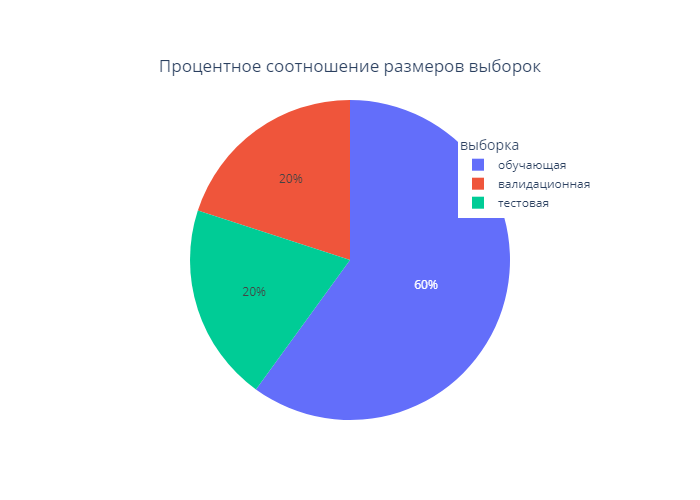

In [90]:
(target_line,
 target_train_line,
 target_valid_line,
 target_test_line,
 features_line,
 features_train_line,
 features_valid_line,
 features_test_line) = split_data (df_line)

#### Масштабирование признаков 

##### Проверка масштаба

Для начала убедимся, что у признаков разный масштаб графически на точечной диаграмме.

Напишем функцию `scaling_plot()`, т.к. действие будет повторяться.
- На вход фунция принимает признаки обучающей, валидационной и тестовой выборок.
- На выходе ничего не возвращает, служит для визуализации разброса значений объектов по признакам.

In [91]:
def scaling_plot(features_train, features_valid, features_test):    
    selection = [features_train, features_valid, features_test]
    title = ['Разброс значений объектов по признакам для обучающей выборки',
             'Разброс значений объектов по признакам для валидационной выборки',
             'Разброс значений объектов по признакам для тестовой выборки']
    
    for i in range(3):
    
        fig, ax = plt.subplots(figsize=(20,5)) 
        
        for column in list(selection[i].columns):
            ax.scatter([column]*len(selection[i]), selection[i][column], alpha=.5, linewidth=7, s = 1)
        
        ax.set_xlabel('Признаки', fontsize=15)
        ax.set_ylabel('Объекты', fontsize=15)
        plt.title(title[i], fontsize=15, y=1.03)
        plt.xticks(rotation = 90)
        plt.rcParams['font.size'] = '13'
        plt.show()

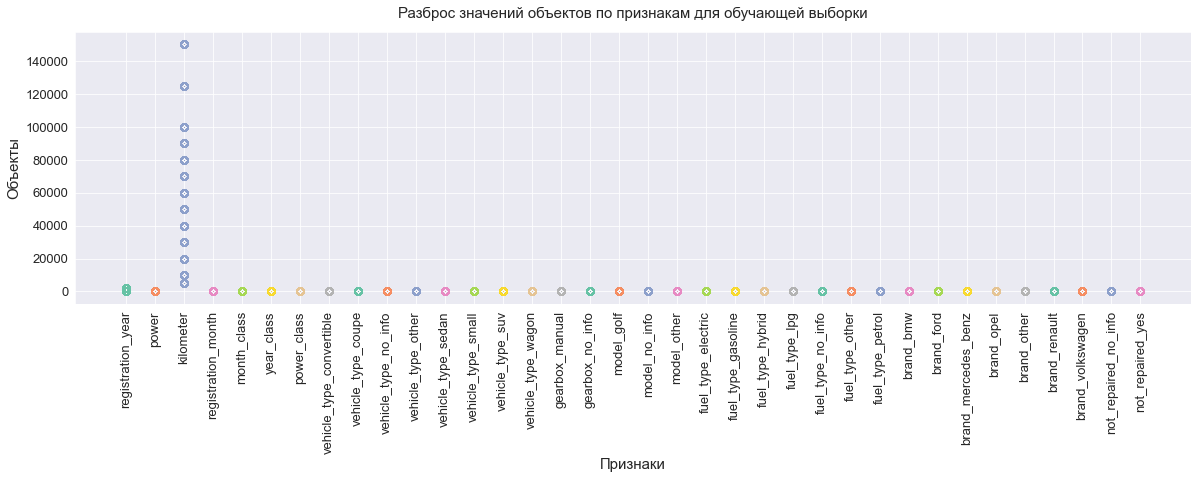

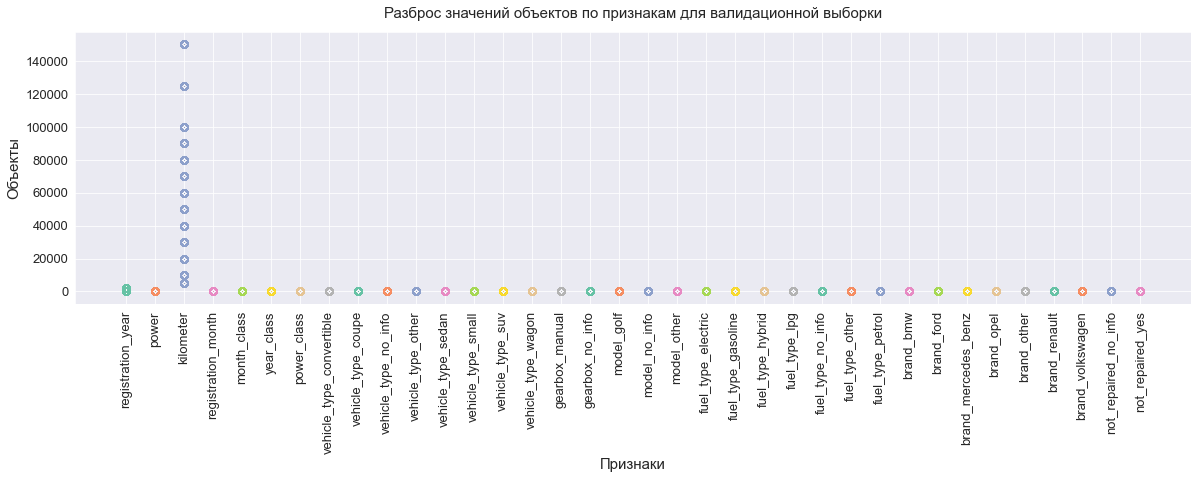

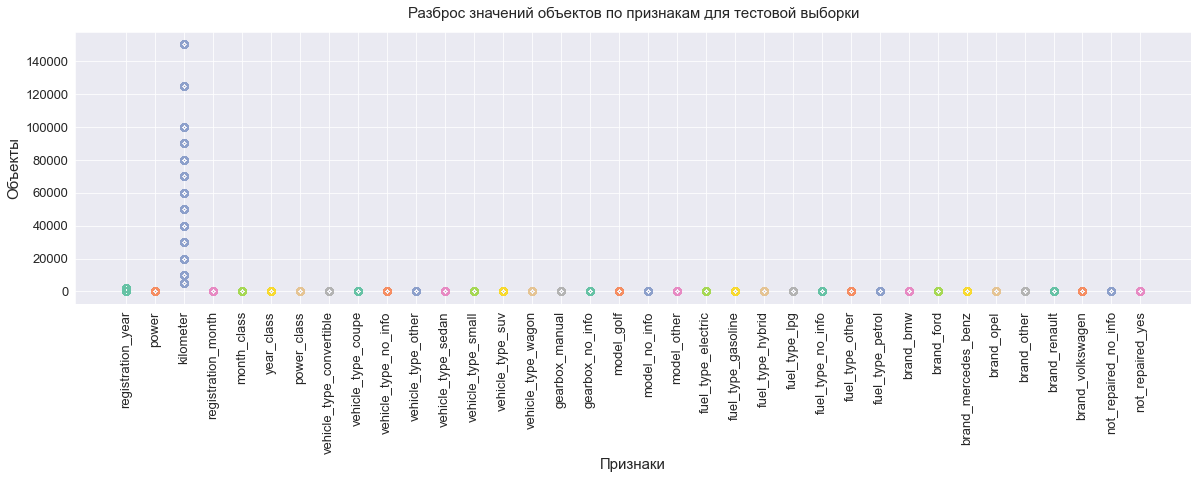

In [92]:
scaling_plot (features_train_line, features_valid_line, features_test_line)

Т.к. у признаков разный масштаб, необходимо их стандартизировать - привести к одному масштабу.

##### Масштабирование

Выполним масштабирование признаков.

In [93]:
numeric = list(features_line.columns)

scaler = StandardScaler()
scaler.fit(features_train_line[numeric])
features_train_line[numeric] = scaler.transform(features_train_line[numeric])
features_valid_line[numeric] = scaler.transform(features_valid_line[numeric])
features_test_line[numeric] = scaler.transform(features_test_line[numeric])

##### Проверка результатов масштабирования

Проверим результаты масштабирования на точечной диаграмме.

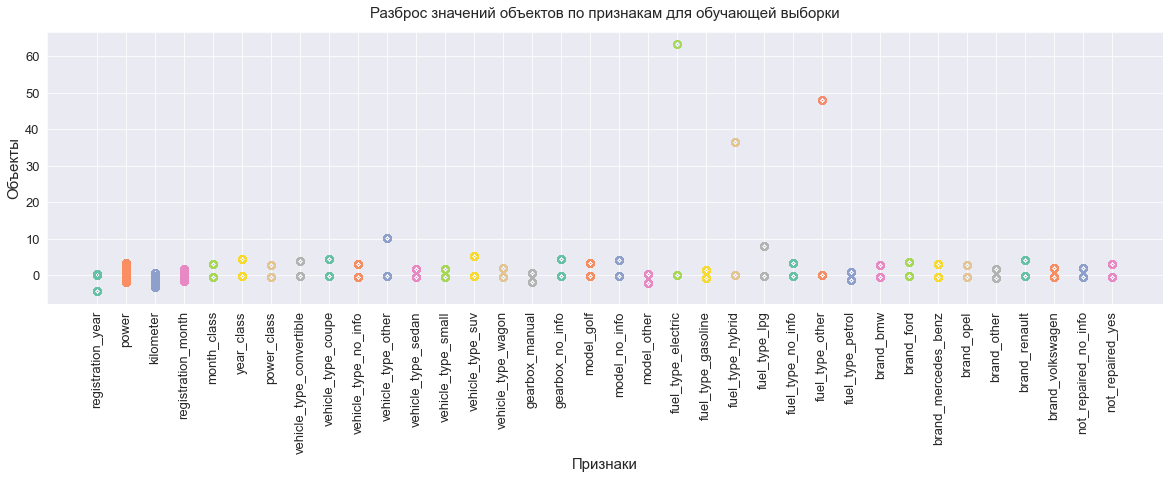

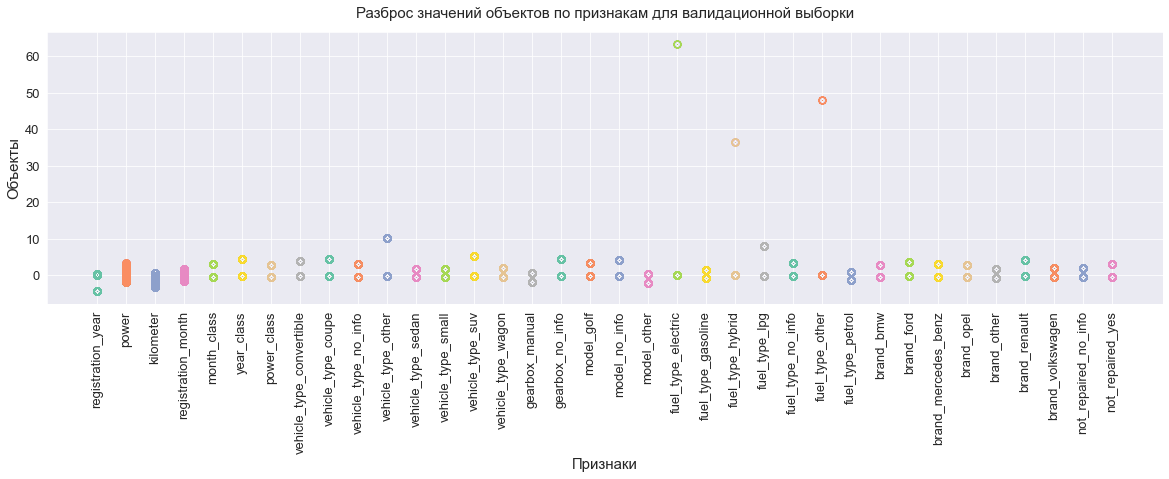

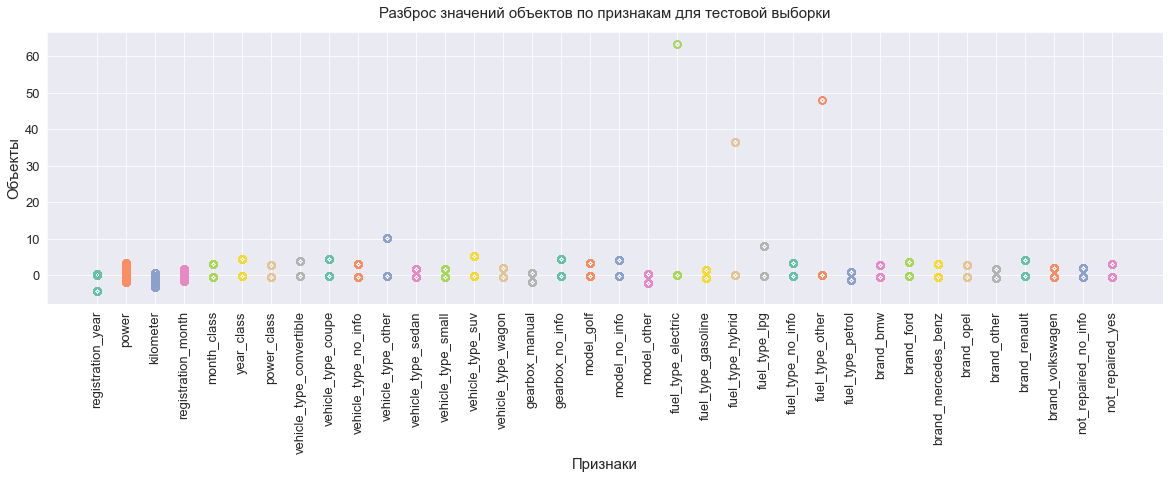

In [94]:
scaling_plot (features_train_line, features_valid_line, features_test_line)

Признаки приведены к одному масштабу.

#### Функция обучения, предсказаний и получения метрик модели

Cоздадим функцию `model_metrics()`.

На входе функции:
- `model` - модель регрессии
- `target_train` - целевой признак обучающей выборки
- `target_test` - целевой признак тестовой (или валидационной) выборки
- `features_train` - признаки обучающей выборки
- `features_test` - признаки тестовой (или валидационной) выборки

На выходе функции:
- `model` - модель
- `metrics` - датафрейм с метриками модели

Датафрейм `metrics`:
- `model` - модель     
- `rmse` - значение метрики RMSE для выбранной модели      
- `rmse_base` - значение метрики RMSE для базовой (константной) модели   
- `rmse_max` - предельное значение метрики RMSE согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели

In [95]:
def model_metrics(model: 'ModelRegressor',
                  target_train: pd.Series,
                  target_test: pd.Series,
                  features_train: pd.DataFrame,
                  features_test: pd.DataFrame):
    
    '''Обучение, предсказания модели, вычисление времени кода'''
    
    start_fit = time.time()
    model.fit(features_train, target_train) # обучение модели
    time_fit = time.time() - start_fit # время обучения модели
    
    start_pred = time.time()
    predictions = model.predict(features_test) # предсказания модели
    time_pred = time.time() - start_pred # время предсказания модели
    
    rmse = rmse_score(target_test, predictions) # вычисление RMSE      
        
    '''Baseline'''
    
    model_base = DummyRegressor()
    
    model_base.fit(features_train, target_train) # обучение модели
    predictions_base = model_base.predict(features_test) # предсказания модели    
    rmse_base = rmse_score(target_test, predictions_base) # вычисление RMSE
    
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'     : [model],
                            'rmse'      : [rmse],
                            'rmse_base' : [rmse_base],
                            'rmse_max'  : [rmse_max],
                            'sanity'    : [rmse < rmse_base],
                            'quality'   : [rmse < rmse_max],
                            'time_fit'  : [time_fit],
                            'time_pred' : [time_pred]})   
    
    display(metrics)
    
    if rmse < rmse_base:
        print(color.OKGREEN+color.BOLD+'Качество лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество уступает базовому уровню, модель невменяема.'+color.END)
    
    if rmse < rmse_max:
        print(color.OKGREEN+color.BOLD+'Качество лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество уступает предельному по исходным данным.'+color.END)    
    
    return model, metrics

#### Линейная регрессия

In [96]:
model_line, metrics_line = model_metrics(LinearRegression(),
                                         target_train_line,
                                         target_valid_line,
                                         features_train_line,
                                         features_valid_line)

model     rmse  rmse_base  rmse_max  sanity  quality  \
0  LinearRegression() 2765.172   4494.289      2500    True    False   

   time_fit  time_pred  
0     0.375      0.020

Качество лучше базового уровня, модель вменяема.
Качество уступает предельному по исходным данным.


#### Гребневая регрессия

In [97]:
model_ridge, metrics_ridge = model_metrics(Ridge(alpha=14000, random_state=42, solver='cholesky'),
                                                 target_train_line,
                                                 target_valid_line,
                                                 features_train_line,
                                                 features_valid_line)

model     rmse  rmse_base  \
0  Ridge(alpha=14000, random_state=42, solver='cholesky') 3124.725   4494.289   

   rmse_max  sanity  quality  time_fit  time_pred  
0      2500    True    False     0.083      0.006

Качество лучше базового уровня, модель вменяема.
Качество уступает предельному по исходным данным.


Простые модели не обеспечили требуемого заказчиком качества.

### CatBoostRegressor

#### Создание переменных для признаков и таргета, деление на выборки

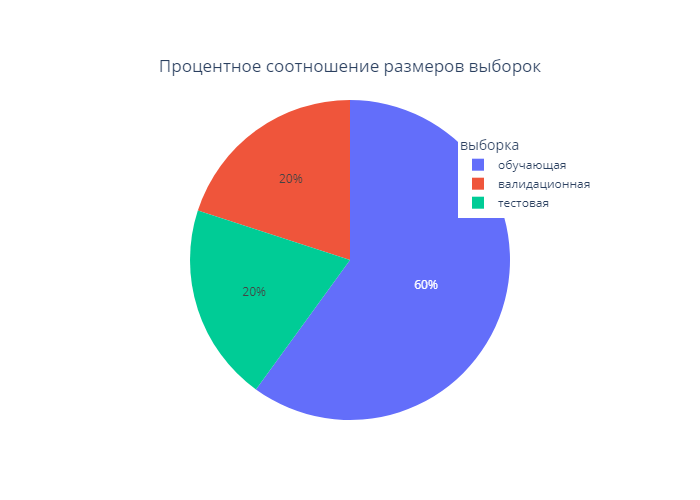

In [98]:
(target_cat,
 target_train_cat,
 target_valid_cat,
 target_test_cat,
 features_cat,
 features_train_cat,
 features_valid_cat,
 features_test_cat) = split_data (df)

#### Создание списка категориальных признаков

In [99]:
cat_features = list(df_types_clean.query('bin_types=="categorical"').index)
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

#### Функция обучения, предсказаний и получения метрик модели

Cоздадим функцию `cat_metrics()`.

На входе функции:
- `parameter_change` - наименование изменяемого гиперпараметра
- `parameter_range` - диапазон изменения гиперпараметра
- `parameters_other` - словарь дополнительных параметров, если дополнительные параметры отсутствуют, то необходимо передать пустой словарь {}
- `target_train` - целевой признак обучающей выборки
- `target_valid` - целевой признак валидационной выборки
- `features_train` - признаки обучающей выборки
- `features_valid` - признаки валидационной выборки

На выходе функции:
- `model_best` - лучшая модель
- `metrics` - датафрейм с метриками модели
- `rmse_best` - лучшее значение метрики `RMSE`

Датафрейм `metrics`:
- `model` - модель     
- `rmse` - значение метрики RMSE для выбранной модели      
- `rmse_base` - значение метрики RMSE для базовой (константной) модели   
- `rmse_max` - предельное значение метрики RMSE согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели
- `best_iteration` - лучшая итерация
- `f'{parameter_change}'` - значения изменяемого гиперпараметра

Функция также выполняет визуализацию результатов.

In [100]:
def cat_metrics(parameter_change:'str_name',
                parameter_range:'range',
                parameters_other:'dict',
                target_train: pd.Series,
                target_valid: pd.Series,
                features_train: pd.DataFrame,
                features_valid: pd.DataFrame):
    
    time_fit_list = []
    time_pred_list = []
    rmse_list = []
    sanity_list = []
    quality_list = []
    iteration_list = []
    
    '''Baseline'''
    
    model_base = DummyRegressor()                          # инициализация модели   
    model_base.fit(features_train, target_train)           # обучение модели
    predictions_base = model_base.predict(features_valid)  # предсказания модели    
    rmse_base = rmse_score(target_valid, predictions_base) # вычисление RMSE
    rmse_best = rmse_base

    '''Обучение, предсказания модели, вычисление времени кода'''
    
    for parameter in parameter_range:
        
        print(f'\033[1m\033[4mОбучение модели при параметре {parameter_change}={parameter}\033[0m')
    
        params = {**{'cat_features'   : cat_features,
                     'eval_metric'    : 'RMSE',
                     'random_seed'    : 42,
                     'verbose'        : False,
                     parameter_change : parameter},
                  
                  **parameters_other}
        
        model = CatBoostRegressor(**params)
        
        start_fit = time.time()     
        model.fit(features_train,
                  target_train,
                  eval_set=(features_valid, target_valid),
                  plot=True)                         # обучение модели        
        time_fit = time.time() - start_fit           # время обучения модели
        
        time_fit_list.append(time_fit)
        
        start_pred = time.time()
        predictions = model.predict(features_valid)  # предсказания модели
        time_pred = time.time() - start_pred         # время предсказания модели
        
        time_pred_list.append(time_pred)
        
        rmse = rmse_score(target_valid, predictions) # вычисление RMSE
        rmse_list.append(rmse)      
        sanity_list.append(rmse < rmse_base)
        quality_list.append(rmse < rmse_max)
        iteration_list.append(model.best_iteration_+1)
        
        '''Выбор лучшей модели'''
        
        if rmse < rmse_best:
            model_best = model
            rmse_best = rmse
            best_parameter = parameter
    
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'               : ['CatBoostRegressor']*len(parameter_range),
                            'rmse'                : rmse_list,
                            'rmse_base'           : [rmse_base]*len(parameter_range),
                            'rmse_max'            : [rmse_max]*len(parameter_range),
                            'sanity'              : sanity_list,
                            'quality'             : quality_list,
                            'time_fit'            : time_fit_list,
                            'time_pred'           : time_pred_list,
                            'best_iteration'      : iteration_list,
                            f'{parameter_change}' : parameter_range}) 
    
    display(metrics)
    
    if rmse_best < rmse_base:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает базовому уровню, модель невменяема.'+color.END)
    
    if rmse_best < rmse_max:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)
        
    '''Визуализация результатов'''
    
    '''Тепловая карта'''  

    fig = make_subplots(rows=1, cols=4, horizontal_spacing=0.15, subplot_titles = ['Метрика<br>RMSE',
                                                                                   'Время<br>обучения',
                                                                                   'Время<br>предсказания',
                                                                                   'Лучшая<br>итерация'])

    for i, x_cbar, f, met, in zip(range(4),
                                  [.15, .435, .722, 1.01],
                                  ['fig1', 'fig2', 'fig3', 'fig4'],
                                  ['rmse', 'time_fit', 'time_pred', 'best_iteration']):
        
        metrics_heat = metrics.set_index(f'{parameter_change}')[[met]]
    
        locals()[f] = go.Heatmap(z = metrics_heat,
                                 x = metrics_heat.columns,
                                 y = metrics_heat.index,
                                 texttemplate='%{z:.2f}',
                                 xgap = 2,
                                 ygap = 2,
                                 ytype = 'scaled',
                                 colorscale = 'RdYlGn_r',
                                 colorbar = dict(len=1.105, thickness=15, x=x_cbar))
        
        fig.add_trace(locals()[f], row=1, col=i+1)
        fig.update_yaxes(tickmode = 'array', tickvals = [0, 1, 2], ticktext = list(metrics_heat.index), row=1, col=i+1)
    
    fig.update_layout(title={'text': 'Сравнение результатов обучения на тепловых картах',
                             'y':0.92,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},                
     
                      width = 900,
                      height = 350,                                    
    
                      yaxis_title=f'Значение<br>гиперпараметра<br>{parameter_change}',
                      autosize = False) 
    
    fig.show('png')    
    
    return model_best, metrics, rmse_best

Обучение модели при параметре learning_rate=0.1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре learning_rate=0.2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре learning_rate=0.3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  CatBoostRegressor 1652.648   4494.289      2500    True     True   234.689   
1  CatBoostRegressor 1648.297   4494.289      2500    True     True   226.532   
2  CatBoostRegressor 1657.810   4494.289      2500    True     True   230.082   

   time_pred  best_iteration  learning_rate  
0      0.440            1000          0.100  
1      0.459             991          0.200  
2      0.493             996          0.300

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


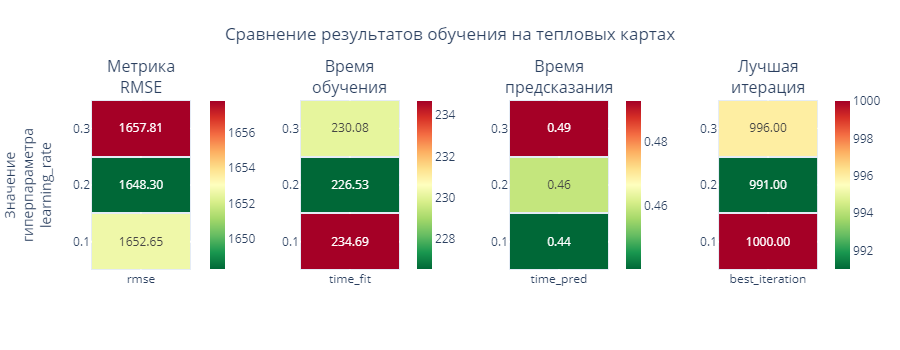

CPU times: total: 35min 45s
Wall time: 11min 33s


In [101]:
%%time
model_cat, metrics_cat, rmse_cat = cat_metrics('learning_rate',
                                               [0.1, 0.2, 0.3],
                                               {'depth':8},
                                               target_train_cat,
                                               target_valid_cat,
                                               features_train_cat,
                                               features_valid_cat)

Обучение модели при параметре depth=5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре depth=8


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре depth=11


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  CatBoostRegressor 1681.957   4494.289      2500    True     True   126.837   
1  CatBoostRegressor 1648.297   4494.289      2500    True     True   217.649   
2  CatBoostRegressor 1656.446   4494.289      2500    True     True   414.550   

   time_pred  best_iteration  depth  
0      0.296            1000      5  
1      0.447             991      8  
2      0.436             549     11

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


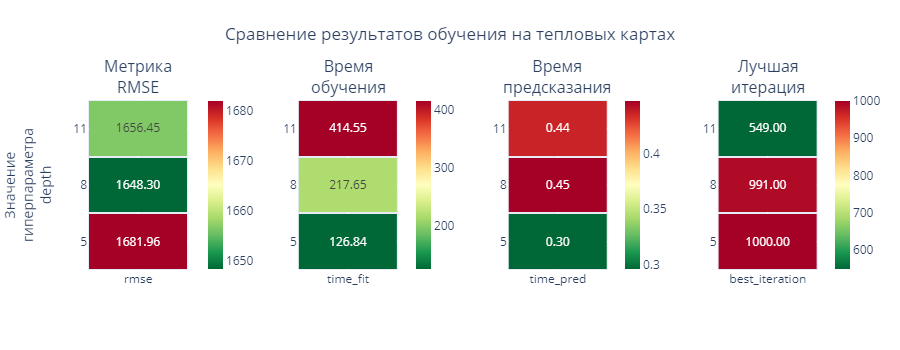

CPU times: total: 41min 43s
Wall time: 12min 40s


In [102]:
%%time
model_cat, metrics_cat, rmse_cat = cat_metrics('depth',
                                               [5, 8, 11],
                                               {'learning_rate': 0.2},
                                               target_train_cat,
                                               target_valid_cat,
                                               features_train_cat,
                                               features_valid_cat)

Обучение модели при параметре loss_function=MAE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре loss_function=MAPE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение модели при параметре loss_function=RMSE


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  CatBoostRegressor 1723.417   4494.289      2500    True     True   211.232   
1  CatBoostRegressor 5569.280   4494.289      2500   False    False   157.487   
2  CatBoostRegressor 1648.297   4494.289      2500    True     True   231.316   

   time_pred  best_iteration loss_function  
0      0.299             990           MAE  
1      0.165             656          MAPE  
2      0.494             991          RMSE

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


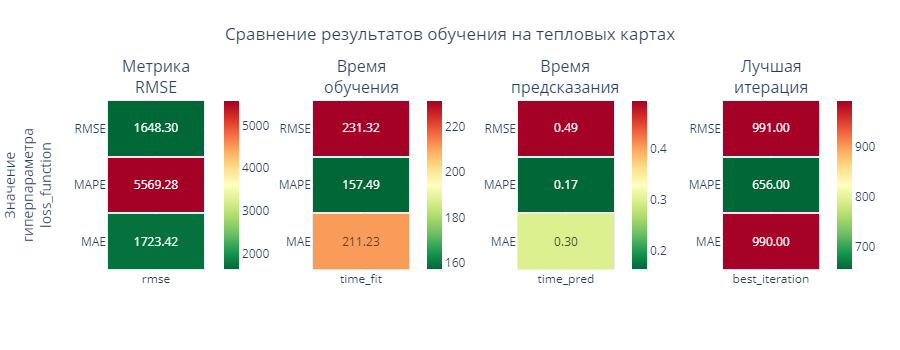

CPU times: total: 30min 36s
Wall time: 10min 1s


In [103]:
%%time
model_cat, metrics_cat, rmse_cat = cat_metrics('loss_function',
                                               ['MAE', 'MAPE', 'RMSE'],
                                               {'learning_rate': 0.2,
                                                'depth': 8},
                                               target_train_cat,
                                               target_valid_cat,
                                               features_train_cat,
                                               features_valid_cat)

#### Лучшая модель

Гиперпараметры лучшей модели

In [104]:
model_cat.get_params()

{'learning_rate': 0.2,
 'depth': 8,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': False,
 'eval_metric': 'RMSE',
 'cat_features': ['vehicle_type',
  'gearbox',
  'model',
  'fuel_type',
  'brand',
  'not_repaired']}

Качество лучшей модели

In [105]:
print(f'RMSE лучшей модели: {rmse_cat:.2f}')

RMSE лучшей модели: 1648.30


### LGBMRegressor

#### Датафрейм для модели lightgbm

Сохраним датафрейм для модели lightgbm в отдельную переменную

In [106]:
df_light = df.copy()

#### Замена типов данных категориальных признаков

Для возможности работы с категориальными признаками в библиотеке `lightgbm` установим для них тип данных `category`

In [107]:
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [108]:
df_light[cat_features] = df_light[cat_features].astype('category')

#### Создание переменных для признаков и таргета, деление на выборки

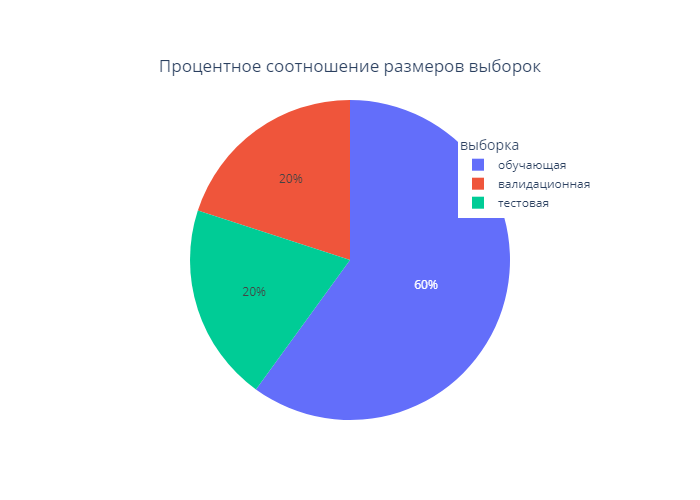

In [109]:
(target_light,
 target_train_light,
 target_valid_light,
 target_test_light,
 features_light,
 features_train_light,
 features_valid_light,
 features_test_light) = split_data (df_light)

#### Обучение с гиперпараметрами по умолчанию

Проверим, как модель работает с параметрами по умолчанию.

In [110]:
model_light_0, metrics_light_0 = model_metrics(LGBMRegressor(random_state=42),
                                               target_train_light,
                                               target_valid_light,
                                               features_train_light,
                                               features_valid_light)

model     rmse  rmse_base  rmse_max  sanity  \
0  LGBMRegressor(random_state=42) 1707.866   4494.289      2500    True   

   quality  time_fit  time_pred  
0     True     0.859      0.248

Качество лучше базового уровня, модель вменяема.
Качество лучше предельного по исходным данным.


#### Функция обучения, предсказаний и получения метрик модели

Cоздадим функцию `light_metrics()`.

На входе функции:
- `parameter_change` - наименование изменяемого гиперпараметра
- `parameter_range` - диапазон изменения гиперпараметра
- `parameters_other` - словарь дополнительных параметров, если дополнительные параметры отсутствуют, то необходимо передать пустой словарь {}
- `target_train` - целевой признак обучающей выборки
- `target_valid` - целевой признак валидационной выборки
- `features_train` - признаки обучающей выборки
- `features_valid` - признаки валидационной выборки

На выходе функции:
- `model_best` - лучшая модель
- `metrics` - датафрейм с метриками модели
- `rmse_best` - лучшее значение метрики `RMSE`

Датафрейм `metrics`:
- `model` - модель     
- `rmse` - значение метрики RMSE для выбранной модели      
- `rmse_base` - значение метрики RMSE для базовой (константной) модели   
- `rmse_max` - предельное значение метрики RMSE согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели
- `best_iteration` - лучшая итерация
- `f'{parameter_change}'` - значения изменяемого гиперпараметра

Функция также выполняет визуализацию результатов.

In [111]:
def light_metrics(parameter_change : 'str_name',
                  parameter_range  : 'range',
                  parameters_other : 'dict',
                  target_train     : pd.Series,
                  target_valid     : pd.Series,
                  features_train   : pd.DataFrame,
                  features_valid   : pd.DataFrame):
    
    time_fit_list = []
    time_pred_list = []
    rmse_list = []
    sanity_list = []
    quality_list = []
    iteration_list = []
    legend_list = []
    evals_list = []
    
    '''Baseline'''
    
    model_base = DummyRegressor()                          # инициализация модели   
    model_base.fit(features_train, target_train)           # обучение модели
    predictions_base = model_base.predict(features_valid)  # предсказания модели    
    rmse_base = rmse_score(target_valid, predictions_base) # вычисление RMSE
    rmse_best = rmse_base
    
    '''Датасеты для обучающей и валидационной выборок'''
    
    train_data = lgb.Dataset(features_train,
                             target_train,
                             categorical_feature=cat_features,
                             free_raw_data=False)
    valid_data = lgb.Dataset(features_valid,
                             target_valid,
                             categorical_feature=cat_features,
                             free_raw_data=False)    
    
    '''Обучение, предсказания модели, вычисление времени кода'''
    
    for parameter in parameter_range:
        
        params = {**{'objective': 'regression',
                     'metric': 'rmse',
                     'verbose': 0,
                     'force_col_wise': True,
                     'num_leaves': 32,
                     'random_seed': 42,
                     parameter_change : parameter},
                  
                  **parameters_other}       
        

        
        start_fit = time.time()
        
        evals_res = {}
        model = lgb.train(params,
                          train_data,
                          valid_sets=[valid_data],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds = 200,
                          categorical_feature=cat_features,
                          evals_result = evals_res)           # обучение модели
        
        time_fit = time.time() - start_fit                    # время обучения модели
        
        time_fit_list.append(time_fit)        

        evals_list.append(evals_res)
        legend_list.append(f'{parameter_change}={parameter}')   

        start_pred = time.time()
        predictions = model.predict(features_valid)           # предсказания модели
        time_pred = time.time() - start_pred                  # время предсказания модели
        
        time_pred_list.append(time_pred)
        
        rmse = rmse_score(target_valid, predictions)          # вычисление RMSE
        rmse_list.append(rmse)      
        sanity_list.append(rmse < rmse_base)
        quality_list.append(rmse < rmse_max)
        iteration_list.append(model.best_iteration)
                
        '''Выбор лучшей модели'''
        
        if rmse < rmse_best:
            model_best = model
            rmse_best = rmse
            best_parameter = parameter           

    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'               : ['LGBMRegressor']*len(parameter_range),
                            'rmse'                : rmse_list,
                            'rmse_base'           : [rmse_base]*len(parameter_range),
                            'rmse_max'            : [rmse_max]*len(parameter_range),
                            'sanity'              : sanity_list,
                            'quality'             : quality_list,
                            'time_fit'            : time_fit_list,
                            'time_pred'           : time_pred_list,
                            'best_iteration'      : iteration_list,
                            f'{parameter_change}' : parameter_range}) 
    
    display(metrics)
    
    if rmse_best < rmse_base:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает базовому уровню, модель невменяема.'+color.END)
    
    if rmse_best < rmse_max:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)
        
    '''Визуализация результатов'''
    
    '''График зависимости метрики RMSE от количества итераций'''
    
    _, ax = plt.subplots(figsize=(15,10))
    
    for e_res in evals_list:
        lgb.plot_metric(e_res,
                        metric = 'rmse',
                        ax=ax)
    ax.set_title('Зависимость метрики RMSE от количества итераций')
    ax.legend(legend_list);
    
    '''Тепловая карта'''  

    fig = make_subplots(rows=1, cols=4, horizontal_spacing=0.15, subplot_titles = ['Метрика<br>RMSE',
                                                                                   'Время<br>обучения',
                                                                                   'Время<br>предсказания',
                                                                                   'Лучшая<br>итерация'])

    for i, x_cbar, f, met, in zip(range(4),
                                  [.15, .435, .722, 1.01],
                                  ['fig1', 'fig2', 'fig3', 'fig4'],
                                  ['rmse', 'time_fit', 'time_pred', 'best_iteration']):
        
        metrics_heat = metrics.set_index(f'{parameter_change}')[[met]]
    
        locals()[f] = go.Heatmap(z = metrics_heat,
                                 x = metrics_heat.columns,
                                 y = metrics_heat.index,
                                 texttemplate='%{z:.2f}',
                                 xgap = 2,
                                 ygap = 2,
                                 colorscale = 'RdYlGn_r',
                                 ytype = 'scaled',
                                 colorbar = dict(len=1.105, thickness=15, x=x_cbar))       
        
        fig.add_trace(locals()[f], row=1, col=i+1)
        fig.update_yaxes(tickmode = 'array', tickvals = [0, 1, 2], ticktext = list(metrics_heat.index), row=1, col=i+1)
    
    fig.update_layout(title={'text': 'Сравнение результатов обучения на тепловых картах',
                             'y':0.92,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},                
     
                      width = 900,
                      height = 350,    
                      yaxis_title=f'Значение<br>гиперпараметра<br>{parameter_change}',
                      autosize = False) 
    
    fig.show('png')    
    
    return model_best, metrics, rmse_best

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LGBMRegressor 1640.612   4494.289      2500    True     True     6.335   
1  LGBMRegressor 1631.325   4494.289      2500    True     True     4.811   
2  LGBMRegressor 1694.112   4494.289      2500    True     True     2.624   

   time_pred  best_iteration  learning_rate  
0      1.478            1000          0.050  
1      1.192             998          0.100  
2      0.328             260          0.500

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


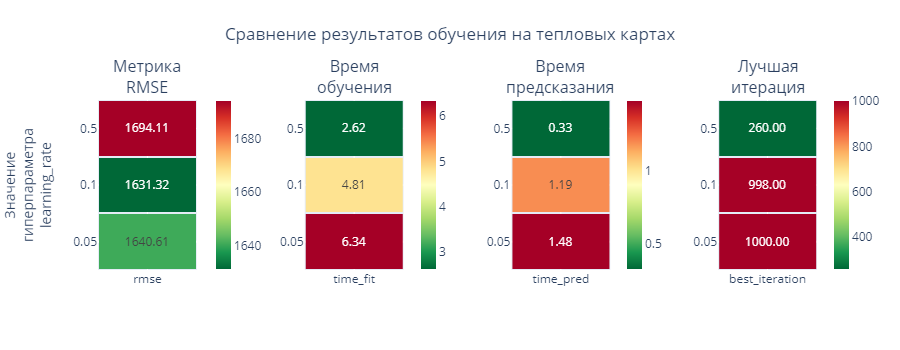

CPU times: total: 1min 3s
Wall time: 17.2 s


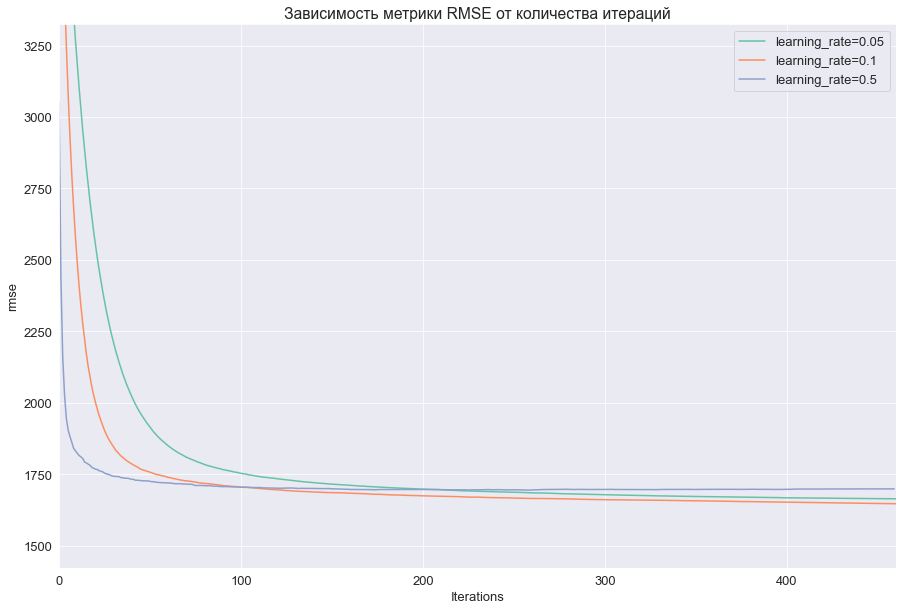

In [112]:
%%time
model_light, metrics_light, rmse_light = light_metrics('learning_rate',
                                                       [0.05, 0.1, 0.5],
                                                       {'max_depth':10},
                                                       target_train_light,
                                                       target_valid_light,
                                                       features_train_light,
                                                       features_valid_light)

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LGBMRegressor 1631.325   4494.289      2500    True     True     5.456   
1  LGBMRegressor 1633.714   4494.289      2500    True     True     4.994   
2  LGBMRegressor 1633.714   4494.289      2500    True     True     5.466   

   time_pred  best_iteration  max_depth  
0      1.183             998         10  
1      1.134            1000         50  
2      1.509            1000        150

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


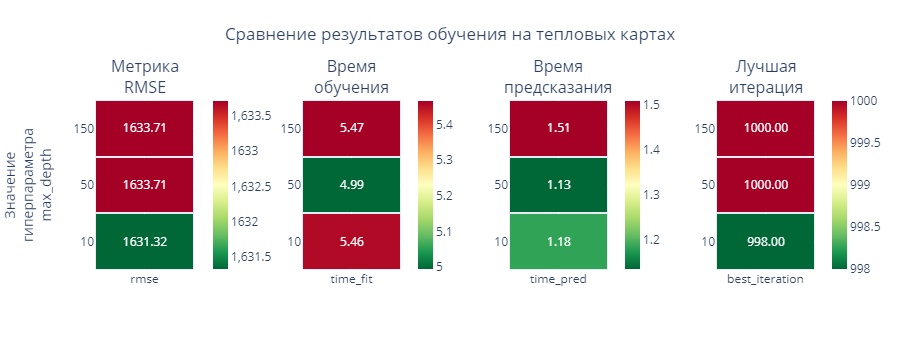

CPU times: total: 1min 13s
Wall time: 20.1 s


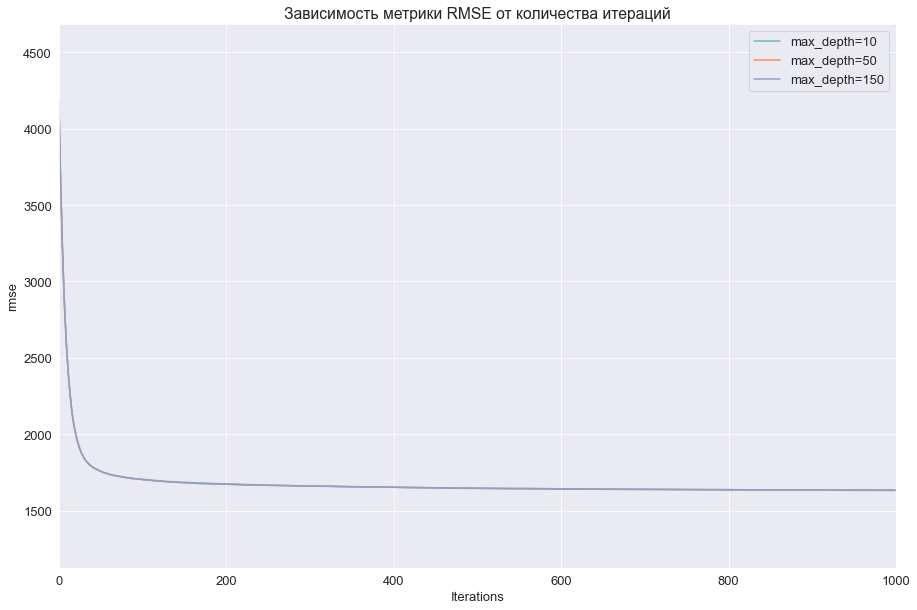

In [113]:
%%time
model_light, metrics_light, rmse_light = light_metrics('max_depth',
                                                       [10, 50, 150],
                                                       {'learning_rate':0.1},
                                                       target_train_light,
                                                       target_valid_light,
                                                       features_train_light,
                                                       features_valid_light)

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LGBMRegressor 1631.325   4494.289      2500    True     True     5.932   
1  LGBMRegressor 1632.580   4494.289      2500    True     True     4.904   
2  LGBMRegressor 1632.580   4494.289      2500    True     True     4.517   

   time_pred  best_iteration  min_split_gain  
0      1.316             998               0  
1      1.432            1000              25  
2      1.136            1000             100

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


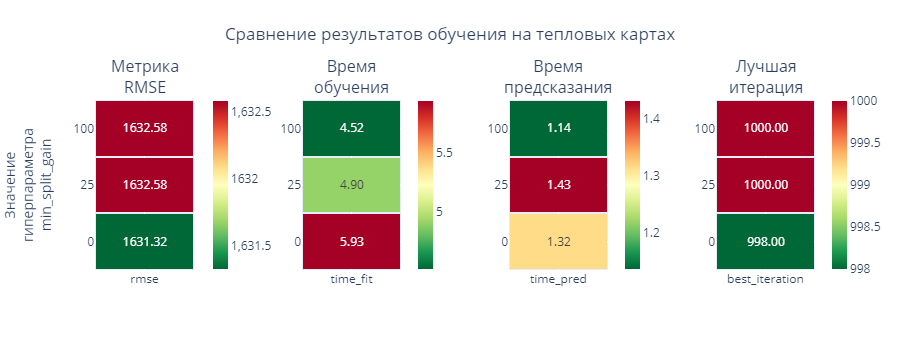

CPU times: total: 1min 12s
Wall time: 19.6 s


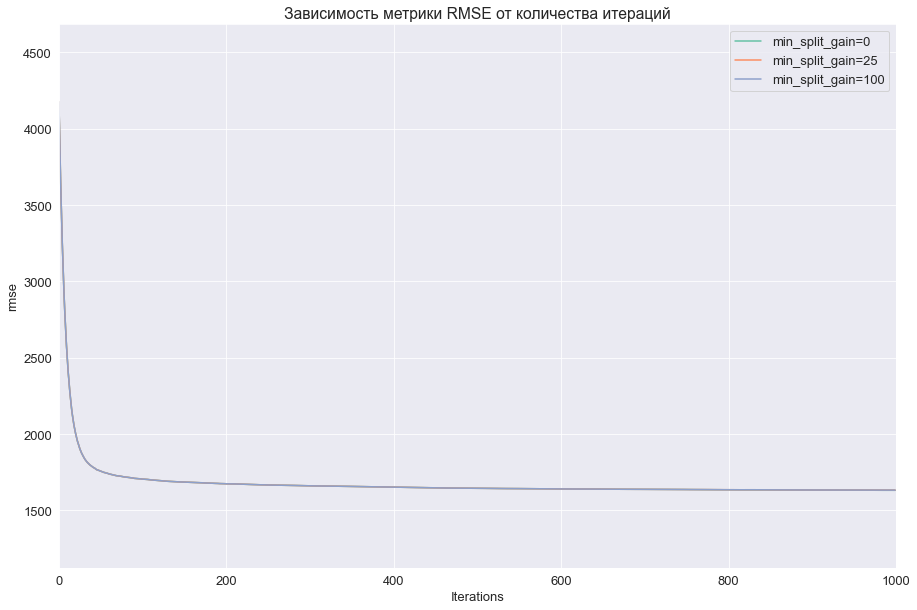

In [114]:
%%time
model_light, metrics_light, rmse_light = light_metrics('min_split_gain',
                                                       [0, 25, 100],
                                                       {'learning_rate':0.1,
                                                        'max_depth':10},
                                                       target_train_light,
                                                       target_valid_light,
                                                       features_train_light,
                                                       features_valid_light)

#### Лучшая модель

Гиперпараметры лучшей модели

In [115]:
model_light.params

{'objective': 'regression',
 'metric': 'rmse',
 'verbose': 0,
 'force_col_wise': True,
 'num_leaves': 32,
 'random_seed': 42,
 'min_split_gain': 0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'num_iterations': 1000,
 'early_stopping_round': 200,
 'categorical_column': [0, 2, 4, 7, 8, 9]}

Качество лучшей модели

In [116]:
print(f'RMSE лучшей модели: {rmse_light:.2f}')

RMSE лучшей модели: 1631.32


### Выбор лучшей модели 

#### Сравнение результатов

Объединим результаты лучших моделей в единый датасет.

In [117]:
metrics_line['model'] = 'LinearRegression'
metrics_ridge['model'] = 'Ridge'

metrics_all = pd.concat([metrics_light.loc[metrics_light['rmse'] == metrics_light['rmse'].min()],
                         metrics_cat.loc[metrics_cat['rmse'] == metrics_cat['rmse'].min()],
                         metrics_line,
                         metrics_ridge]).set_index('model')

metrics_all = metrics_all[['rmse', 'time_fit', 'time_pred']].sort_values(by='rmse', ascending=False)

Сравним метрики графически.

In [118]:
def compare_metrics(metrics: pd.DataFrame):    
    fig = make_subplots(rows=1, cols=3, horizontal_spacing=0.3, subplot_titles = ['Метрика<br>RMSE',
                                                                                   'Время<br>обучения',
                                                                                   'Время<br>предсказания'])
    for i, x_cbar, zmin, zmid, f, c_scale, met, in zip(range(3),
                                                       [.15, .585, 1.02],
                                                       [False, 0, 0], 
                                                       [rmse_max, False, False],                                           
                                                       ['fig1', 'fig2', 'fig3'],
                                                       ['RdBu_r', 'Blues_r', 'Blues_r'],
                                                       ['rmse', 'time_fit', 'time_pred']):
        
        metrics_heat = metrics[[met]]
    
        locals()[f] = go.Heatmap(z = metrics_heat,
                                 x = metrics_heat.columns,
                                 y = metrics_heat.index,
                                 texttemplate='%{z:.2f}',
                                 xgap = 2,
                                 ygap = 2, zmin = zmin, zmid = zmid,
                                 colorscale = c_scale,
                                 colorbar = dict(len=1.105, thickness=15, x=x_cbar))       
        
        fig.add_trace(locals()[f], row=1, col=i+1)
    
    fig.update_layout(title={'text': 'Сравнение метрик моделей на тепловых картах',
                             'y':0.92,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},                
     
                      width = 1000,
                      height = 350,    
                      yaxis_title=f'Наименование модели',
                      autosize = False) 
    
    fig.show('png')

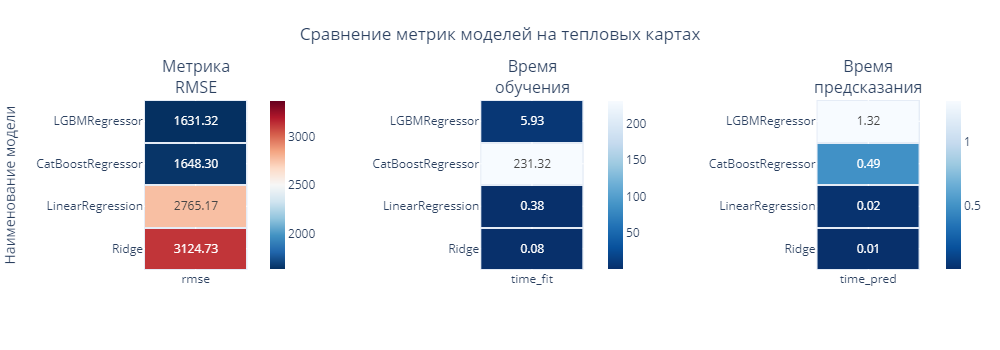

In [119]:
compare_metrics(metrics_all)

- Качество линейных моделей уступает предельному по исходным данным.
- Лучшая по качеству и времени обучения модель - `LGBMRegressor`.
- Время предсказания `LGBMRegressor` незначительно уступает времени предсказания модели `CatBoostRegressor`.
- Для заказчика наиболее оптимальной является модель `LGBMRegressor`.

### Проверка качества лучшей модели на тестовой выборке

#### Проверка качества модели, обученной на 60% данных

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LGBMRegressor 1623.941   4535.788      2500    True     True     5.710   
1  LGBMRegressor 1688.416   4535.788      2500    True     True     1.632   

   time_pred  best_iteration  learning_rate  
0      1.369             993          0.100  
1      0.196             162          0.500

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


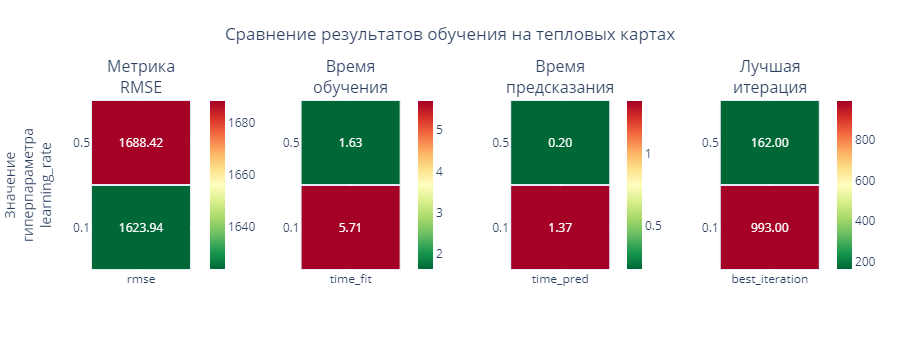

CPU times: total: 33.7 s
Wall time: 9.34 s


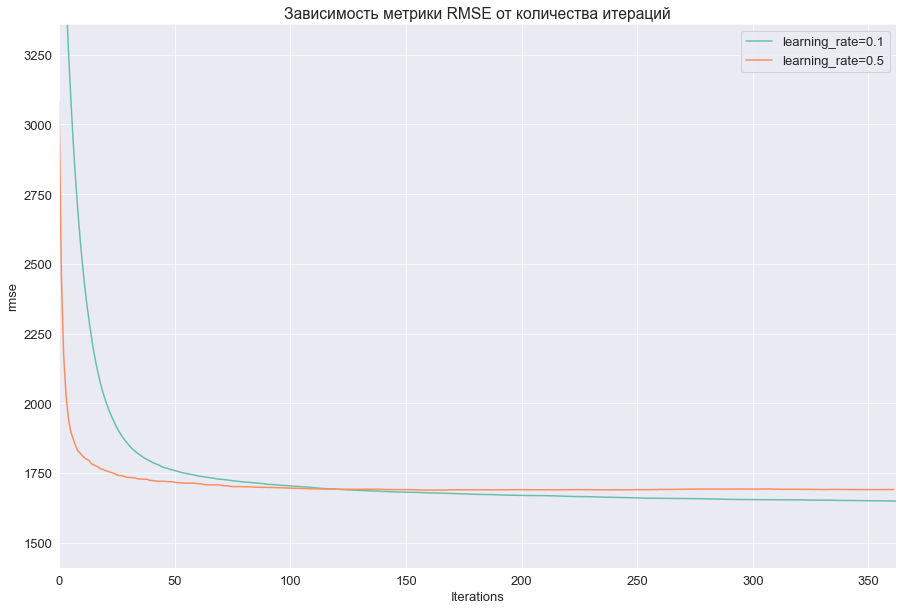

In [120]:
%%time
model_light_60, metrics_light_60, rmse_light_60 = light_metrics('learning_rate',
                                                                [0.1, 0.5],
                                                                {'max_depth':10},
                                                                target_train_light,
                                                                target_test_light,
                                                                features_train_light,
                                                                features_test_light)

#### Проверка качества модели, обученной на 80% данных

Объединим обучающую и валидационную выборки

In [121]:
target_full_light = pd.concat([target_train_light, target_valid_light])
features_full_light = pd.concat([features_train_light, features_valid_light])

model     rmse  rmse_base  rmse_max  sanity  quality  time_fit  \
0  LGBMRegressor 1611.205   4535.805      2500    True     True    26.831   
1  LGBMRegressor 1664.706   4535.805      2500    True     True     3.555   

   time_pred  best_iteration  learning_rate  
0      1.146             993          0.100  
1      0.445             391          0.500

Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


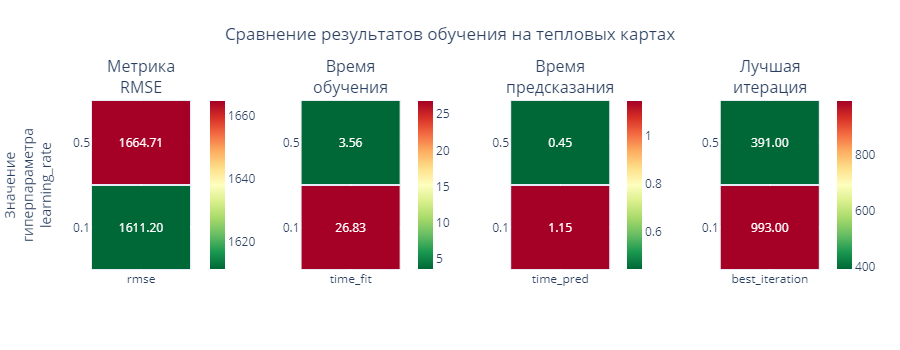

CPU times: total: 1min 35s
Wall time: 32.3 s


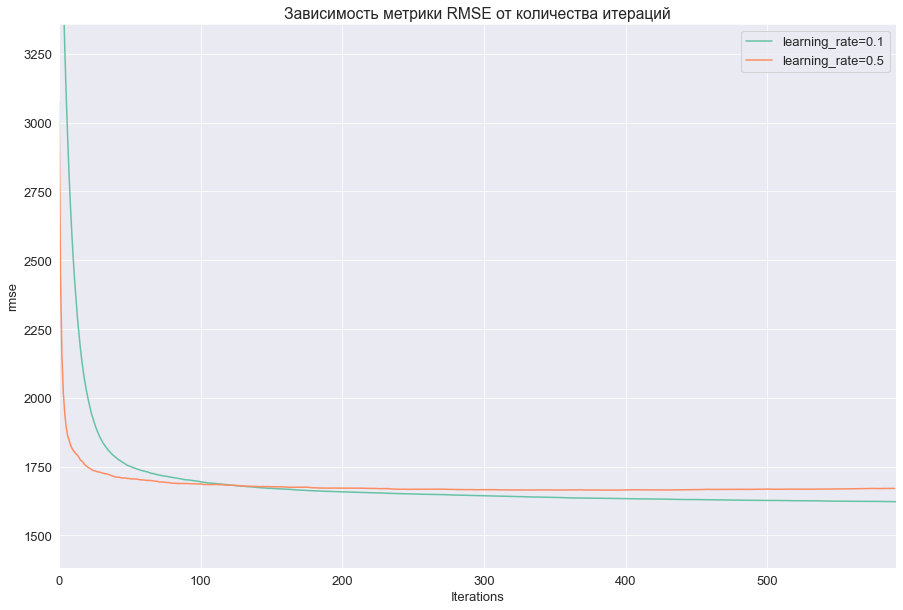

In [122]:
%%time
model_light_80, metrics_light_80, rmse_light_80 = light_metrics('learning_rate',
                                                                [0.1, 0.5],
                                                                {'max_depth':10},
                                                                target_full_light,
                                                                target_test_light,
                                                                features_full_light,
                                                                features_test_light)

Объединим результаты лучших моделей в единый датасет.

In [123]:
metrics_light_60['model'] = 'LGBMRegressor_60'
metrics_light_80['model'] = 'LGBMRegressor_80'

metrics_test = pd.concat([metrics_light_60.loc[metrics_light_60['rmse'] == metrics_light_60['rmse'].min()],
                         metrics_light_80.loc[metrics_light_80['rmse'] == metrics_light_80['rmse'].min()]
                        ]).set_index('model')

metrics_test = metrics_test[['rmse', 'time_fit', 'time_pred']].sort_values(by='rmse', ascending=False)

Сравним метрики графически.

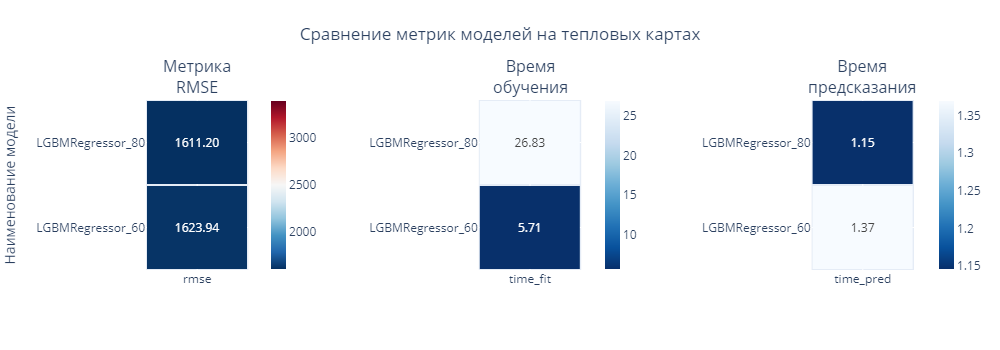

In [124]:
compare_metrics(metrics_test)

Лучшая модель - обученная на 80% данных при подобранных на валидации гиперпараметрах.

Сохраним предсказания лучшей модели в отдельную переменную.

In [125]:
pred_test_light = model_light_80.predict(features_test_light) # предсказания модели

Качество лучшей модели.

In [126]:
print(f'RMSE лучшей модели на тестовой выборке: {rmse_light_80:.2f}')

RMSE лучшей модели на тестовой выборке: 1611.20


Модель прошла проверку на тестовой выборке, качество удовлетворяет требованиям заказчика.

## Интерпретация результатов машинного обучения

### Сравнение распределений данных между целевым признаком и предсказаниями

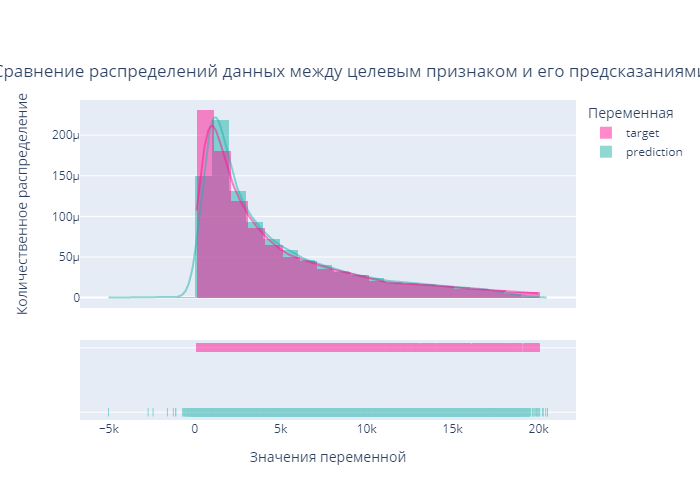

In [127]:
hist_data = [pred_test_light, target_test_light]

group_labels = ['prediction', 'target']
colors = ['lightseagreen', 'deeppink']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colors, bin_size=1000)

fig.update_layout(title={'text': 'Сравнение распределений данных между целевым признаком и его предсказаниями',
                         'y':0.87,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  
                  legend_title=dict(text='Переменная'),
                  
                  xaxis_title='Значения переменной',
                  yaxis_title='Количественное распределение')

fig.update_traces(opacity=0.5)

fig.show('png')

- Смещение данных относительно нормального распределения отрицательно влияет на качество модели, для дальнейшего улучшения качества необходимо согласовать с заказчиком удаление выбивающихся значений (выбросов).
- Большинство значений предсказаний находятся в диапазоне от 0 до 10 000.

### Влияние признаков на предсказания

Сбросим индексы

In [128]:
target_test_light = target_test_light.reset_index(drop=True)

pred_test_light = pd.DataFrame(pred_test_light)
pred_test_light = pred_test_light.reset_index(drop=True)
pred_test_light.columns = ['price_pred']

features_test_light = features_test_light.reset_index(drop=True)

#### Пояснение предсказаний модели с помощью SHAP

In [129]:
%%time
explainer = shap.TreeExplainer(model_light_80)
shap_values = explainer.shap_values(features_test_light)

CPU times: total: 11min 56s
Wall time: 3min 19s


#### Подготовка данных

Сохраним список столбцов признаков в отдельную переменную

In [130]:
X = features_test_light.columns

Сохраним список столбцов вкладов признаков в предсказание в отдельную переменную

In [131]:
shap_cols = [x+'_shap' for x in X]

Создадим датасет `shap_values_df` из значений вкладов признаков в предсказание

In [132]:
shap_values_df = pd.DataFrame(shap_values, columns = shap_cols)

Объединим датасеты `target_test_light`, `pred_test_light`, `features_test_light` и `shap_values_df` в общий датасет `test_shap`

In [133]:
test_shap = pd.concat([target_test_light, pred_test_light, features_test_light, shap_values_df],axis=1)

In [134]:
test_shap.head()

price  price_pred vehicle_type  registration_year  gearbox  power  \
0  17900   15591.869        coupe               2010   manual    245   
1   7600    3152.120          bus               1995   manual     68   
2   6950    5983.407        small               2009   manual     60   
3   3700    3787.010        wagon               2006  no_info      0   
4   5200    8869.016          bus               2008   manual    140   

         model  kilometer  registration_month fuel_type  ...  \
0          3er     150000                   1  gasoline  ...   
1  transporter     150000                   6  gasoline  ...   
2         polo      80000                  12    petrol  ...   
3        focus     100000                   9  gasoline  ...   
4        s_max     150000                   7  gasoline  ...   

  vehicle_type_shap registration_year_shap  gearbox_shap  power_shap  \
0          1014.441               5477.551       -78.440    3835.572   
1           415.214              -2693.742      -110.009   -1622.852   
2          -272.472               2993.007       -98.804   -2055.361   
3          -202.845                914.224      -412.187    -994.206   
4           191.921               3014.720       -68.724     537.831   

   model_shap  kilometer_shap  registration_month_shap  fuel_type_shap  \
0     593.767        -669.336                  -94.222         275.006   
1    2362.763        -373.201                   25.481          98.773   
2    -346.236         770.449                  111.327        -155.358   
3    -360.009         762.701                   63.388        -122.492   
4    1141.094        -756.615                  118.995         223.575   

   brand_shap  not_repaired_shap  
0     853.006           -195.003  
1     195.781            274.385  
2     257.701            199.624  
3    -666.607            225.515  
4    -265.899            152.591  

[5 rows x 22 columns]

Добавим в созданный датасет столбец со значениями ошибок в предсказаниях

In [135]:
test_shap['error'] = test_shap['price_pred'] - test_shap['price']

Посмотрим на распределение ошибок графически

In [136]:
def hist_col(df: pd.DataFrame, x: str, title: str):
    
    fig = px.histogram(df, x=x, nbins=50)
    
    fig.update_layout(title={'text': title,
                             'y':0.94,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'})
    
    fig.show('png')

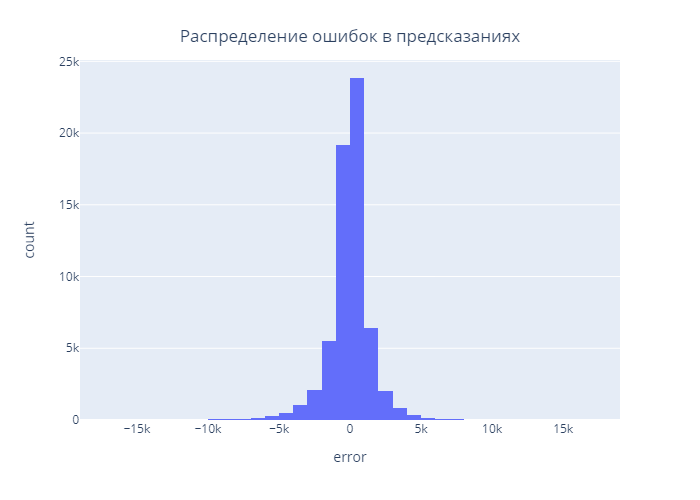

In [137]:
hist_col (test_shap, 'error', 'Распределение ошибок в предсказаниях')

- В основном модель отклоняется от целевого признака в диапазоне от -5000 до 5000.

Добавим в созданный датасет столбец со значениями абсолютных ошибок в предсказаниях

In [138]:
test_shap['error_abs'] = abs(test_shap['error'])

Посмотрим на распределение абсолютных ошибок графически

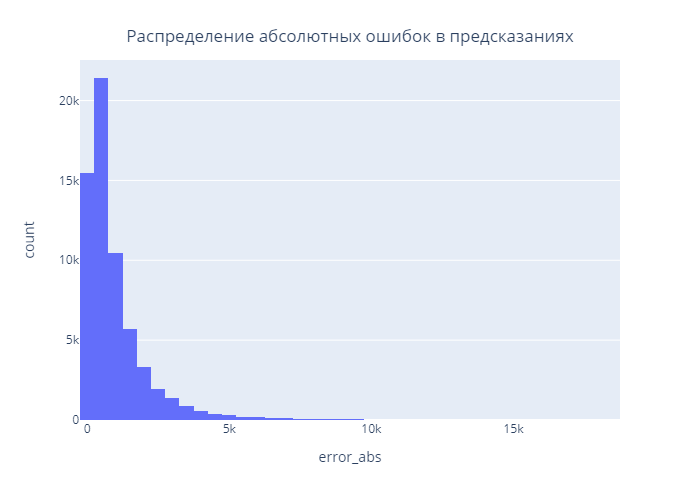

In [139]:
hist_col (test_shap, 'error_abs', 'Распределение абсолютных ошибок в предсказаниях')

Отсортируем данные по значениям абсолютной ошибки в порядке убывания и сохраним результат в отдельную переменную.

In [140]:
test_shap_top = test_shap.sort_values('error_abs', ascending=False)

#### Cводный график важности признаков

Построим сводный график важности признаков.
<br>Пояснения к графику:
- по оси x значения вклада в предсказания (значения Шепли),
- признаки расположены на оси y по мере уменьшения их важности,
- каждая точка – отдельное наблюдение,
- чем толще линия на графике, тем больше таких точек наблюдения,
- цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

Дополнительно к основному сводному графику добавим столбчатую диаграмму средних значений вкладов признаков в предсказания.

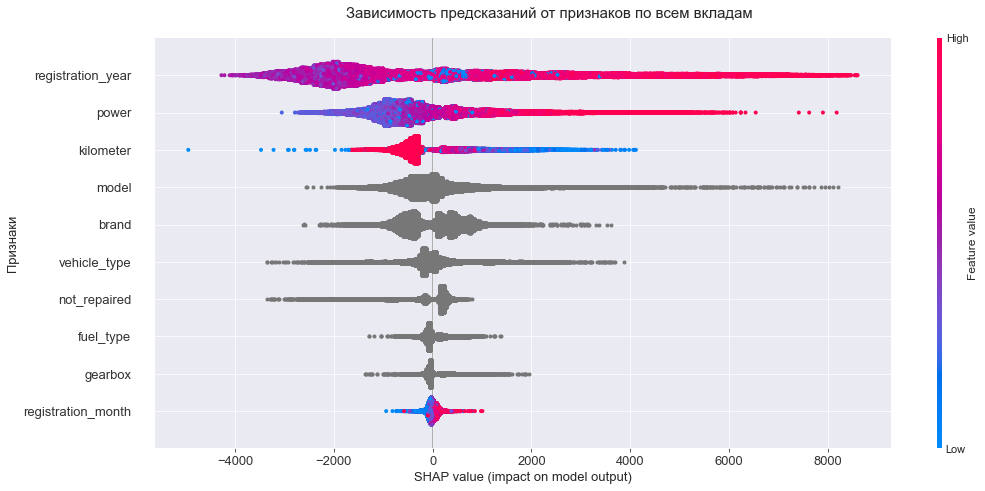

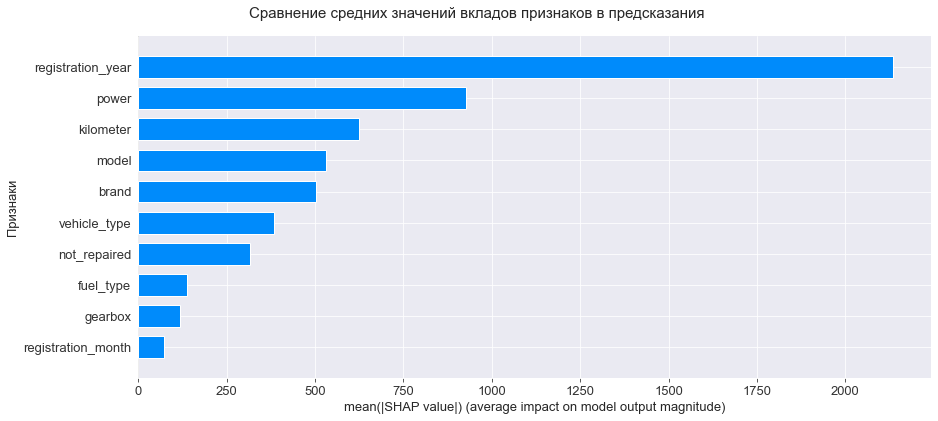

In [141]:
fig, _ = plt.subplots()

fig.suptitle('Зависимость предсказаний от признаков по всем вкладам', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test_light, plot_size=(15,7), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

fig, _ = plt.subplots()

fig.suptitle('Сравнение средних значений вкладов признаков в предсказания', y=.97, fontsize=15)

shap.summary_plot(shap_values, features_test_light, plot_type="bar", plot_size=(13,6), show=False)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Признаки', fontsize=13)

plt.show()

Опишем количественные признаки:
- год вносит максимальный вклад в предсказания, причём явная зависимость не наблюдается (с увеличением года предсказания как занижаются, так и завышаются)
- мощность на втором месте по вкладу в предсказания, с увеличением мощности предсказания завышаются
- пробег на третьем месте по вкладу в предсказания, с увеличением пробега предсказания занижаются
- месяц вносит минимальный вклад в предсказания, с увеличением номера месяца предсказания завышаются

#### Пояснения к графикам аддитивной силы

Визуализируем заданные значения `SHAP` с помощью графика аддитивной силы.<br>График показывает, как разные признаки влияют на итоговое предсказание модели.
- `base value` (базовое значение) – среднее значение, полученное при обучении;
- жирным выделено полученное значение `base value`;
- если значение вклада положительное (красный цвет), то оно увеличивает предсказание, если отрицательное (синий цвет) - уменьшает;
- графики выполняются как интерактивными, так и в формате библиотеки `matplotlib`, в зависимости от задачи визуализации.

#### Графики аддитивной силы для признаков с максимальными ошибками

Проанализируем объекты с 10 самыми большими абсолютными ошибками.

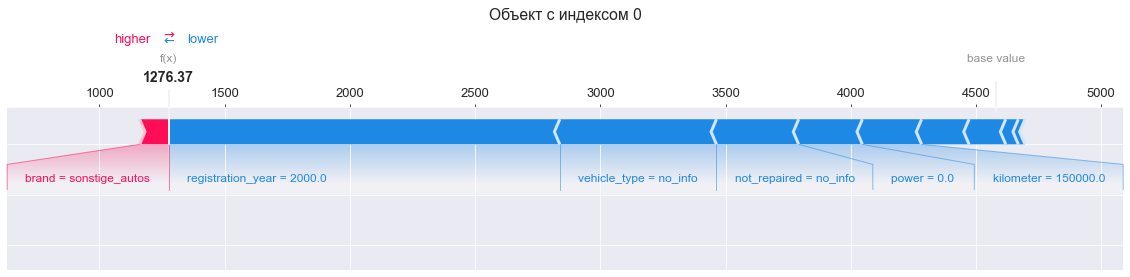

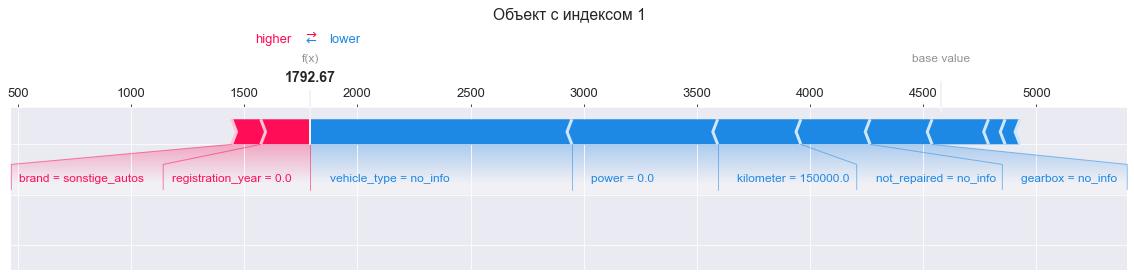

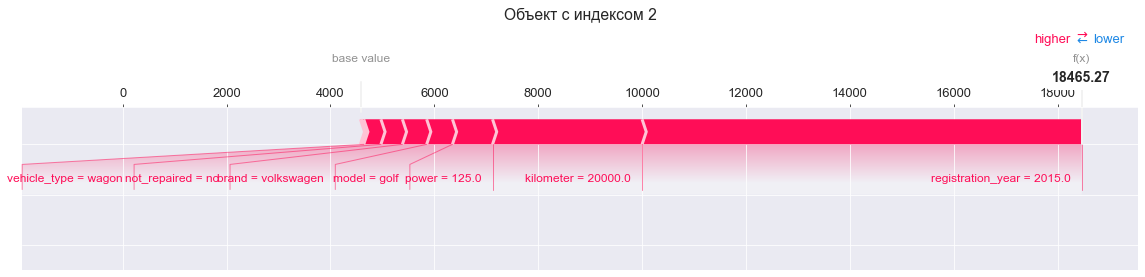

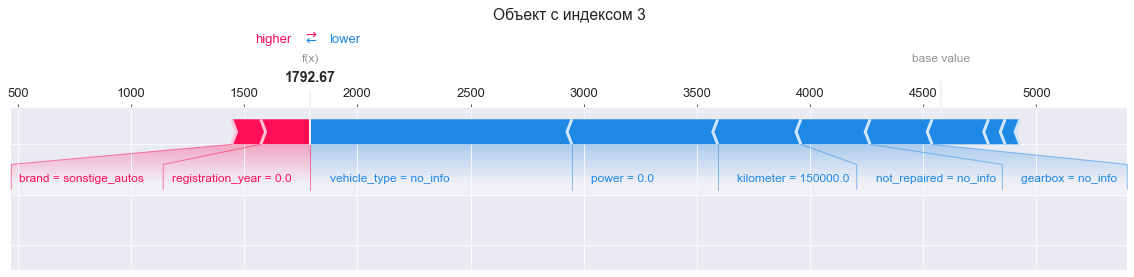

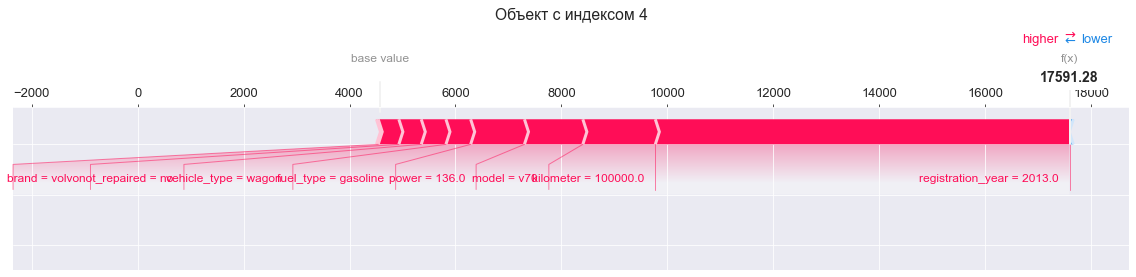

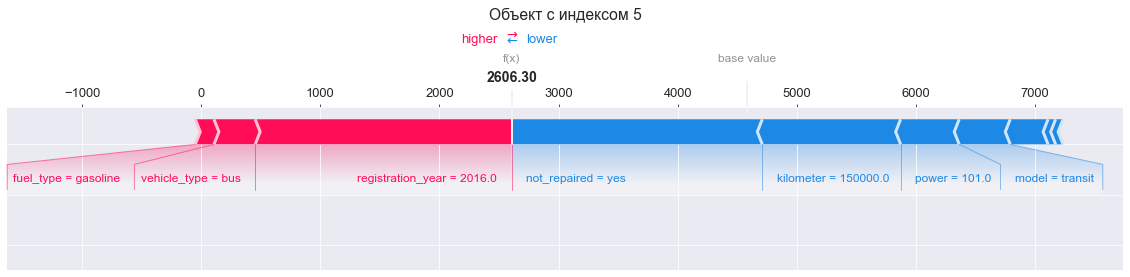

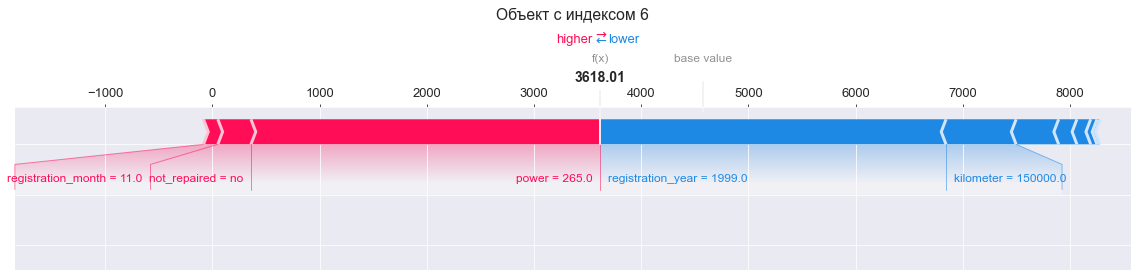

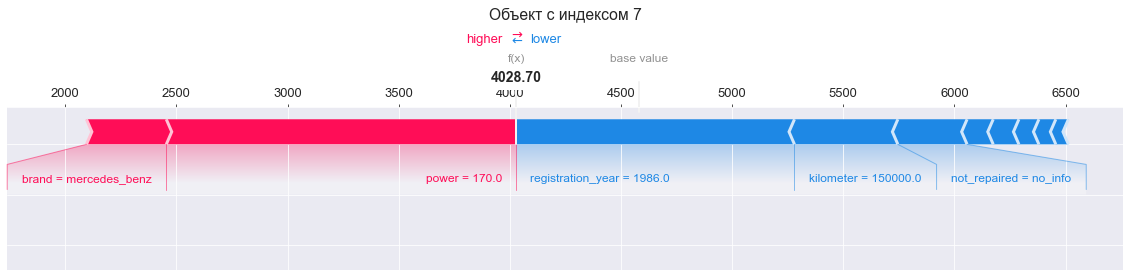

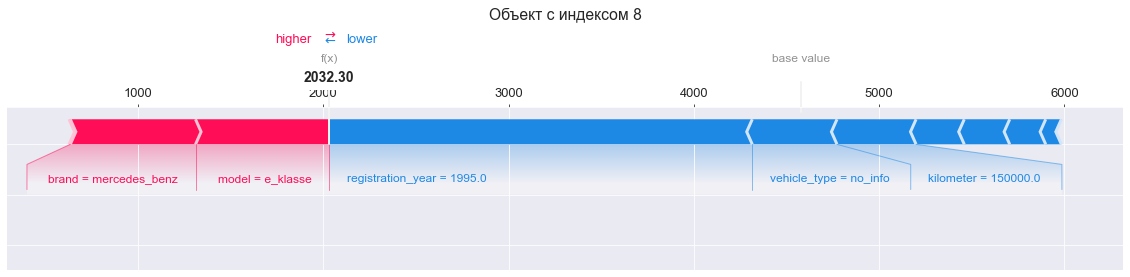

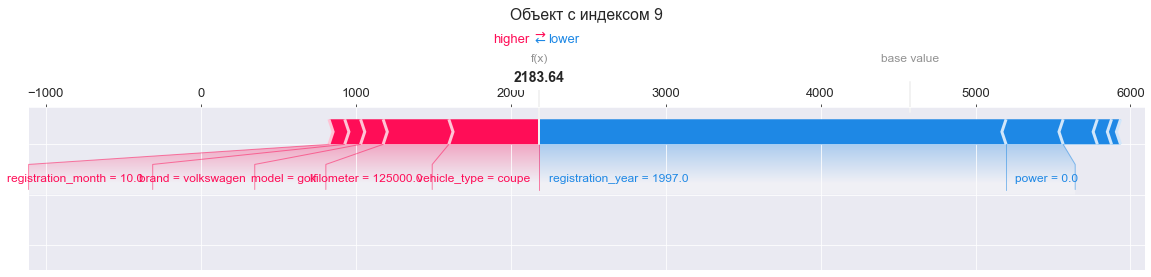

In [142]:
for i in range(10):  
   
    shap.force_plot(explainer.expected_value,
                    test_shap_top[shap_cols].values[i,:],
                    test_shap_top[X].iloc[i,:],
                    matplotlib=True, show=0)
    
    plt.title(f'Объект с индексом {i}', y=1.5)

Выполним график аддитивной силы сразу для всех 10 объектов.

Мы буквально переворачиваем график, полученный выше, на 90 градусов, и повторяем операцию для каждого наблюдения, а затем соединяем всё в один. Это позволяет увидеть интерпретации сразу для каждого наблюдения.

- Графики выполним в интерактивном формате `javascript`, добавив функцию `shap.initjs()`.
- Для анализа поочередно выбираются и сравниваются признаки в левой центральной части графиков и применяется тип сортировки объектов в признаках в верхней центральной части графиков.

In [143]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].head(10).values,
                                          test_shap[X].head(10))

Проанализируем количественные признаки.

<ins>Год регистрации:
- признак чаще занижает вклад
- модуль завышения вклада больше чем модуль занижения вклада 
    
<ins>Мощность:
- признак чаще завышает вклад
- модуль завышения вклада больше чем модуль занижения вклада 
    
<ins>Пробег:
- признак чаще завышает вклад
- с уменьшением пробега наблюдается большая склонность к завышению вклада
- при пробеге менее 90 000 вклад начинает уменьшаться
    
<ins>Месяц регистрации:
- признак чаще завышает вклад
- модуль завышения вклада больше чем модуль занижения вклада
- при значении месяца от 6 до 12 - завышение вклада
- при значении месяца от 1 до 6 - занижение вклада    

Добавим в список признаков абсолютную ошибку и сохраним результат в отдельную переменную.

In [144]:
X_error_abs = list(X)
X_error_abs.append('error_abs')

Посмотрим разброс значений среди объектов с максимальной абсолютной ошибкой.

In [145]:
cm = sns.light_palette('royalblue', as_cmap=True)
test_shap_top[X_error_abs].head(10).style.background_gradient(cmap=cm)

- Модель сильно ошибается при наличии в исходных данных пропусков, которые были заменены в ходе текущей работы.
- Для улучшения качества модели необходимо уточнить у заказчика причину пропусков, после этого принять решение о замене либо удалении.
- Удаление данных с пропусками может также привести и к ухудшению качества на новых данных, которые модель не видела при обучении.
- Чаще модель работает с максимальной ошибкой на максимальном в датасете пробеге, возможно, из-за того что значений пробега 150 000 - максимальное количество в датасете.
- Чаще всего модель работает с максимальной ошибкой при типе автомобильного кузова 'wagon' и марке 'sonstige_autos' (это просто обозначение б/у автомобителей).
- Неопреденность в датасете напрямую влияет на ошибки в модели, при работе с заказчиком и возможности внесения корректировок в датасет качество можно улучшить.

#### Интерактивный график аддитивной силы для произвольного объекта

Построим интерактивный график аддитивной силы для произвольного объекта.

Выберем случайный индекс (`i_r` - index random) при помощи функции `randint` из библиотеки `random`, предварительно применив функцию начального числа `seed` для неизменности полученного результата после перезагрузки ядра ноутбука.

In [146]:
random.seed(42)
i_r = random.randint(0,len(test_shap))
i_r

41905

In [147]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap[shap_cols].values[i_r,:], test_shap[X].iloc[i_r,:])

Вклады в предсказание.

In [148]:
pd.DataFrame(test_shap.loc[i_r, shap_cols]).sort_values(by=i_r, ascending=False)

41905
registration_year_shap   1423.818
registration_month_shap   118.636
fuel_type_shap            108.981
vehicle_type_shap          16.920
not_repaired_shap         -57.589
gearbox_shap             -118.410
kilometer_shap           -405.618
brand_shap               -867.032
model_shap              -1186.702
power_shap              -1207.623

- Наибольший вклад в предсказание оказывают признаки `registration_year` и `power`, причём один из признаков увеличивает предсказание, а другой - уменьшает.

#### Зависимость вклада в предсказания модели от каждого признака на точечных диаграммах

##### Функция для построения точечных диаграмм

In [149]:
def dependence_test (col: 'col_name', xlim: 'range or None'):    
    fig, axes = plt.subplots(figsize=(20, 10))
    fig.suptitle(f'Зависимость вклада в предсказания от признака {col}', y=.92)
    
    shap.dependence_plot(col,
                         shap_values,
                         features_test_light,
                         show=False,
                         ax=axes)
    
    if col == 'model':
        axes.xaxis.set_major_locator(ticker.NullLocator())
        
    axes.set_xlim(xlim);

##### Тип кузова

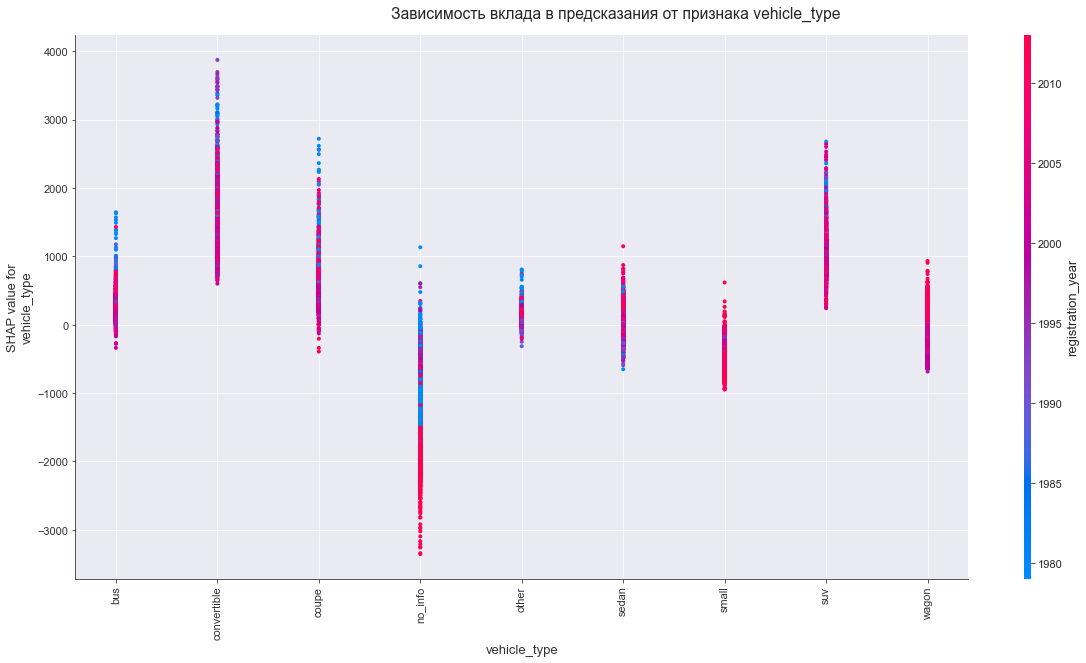

In [150]:
dependence_test('vehicle_type', xlim = None)

- Пропуски максимально влияют на занижение предсказания.
- Тип кузова `convertible (кабриолет)` максимально завышает предсказания, т.к. это не самый популярный тип кузова и вычислить взаимосвязи по данному значению в признаке модели тяжелее.

##### Год регистрации автомобиля	

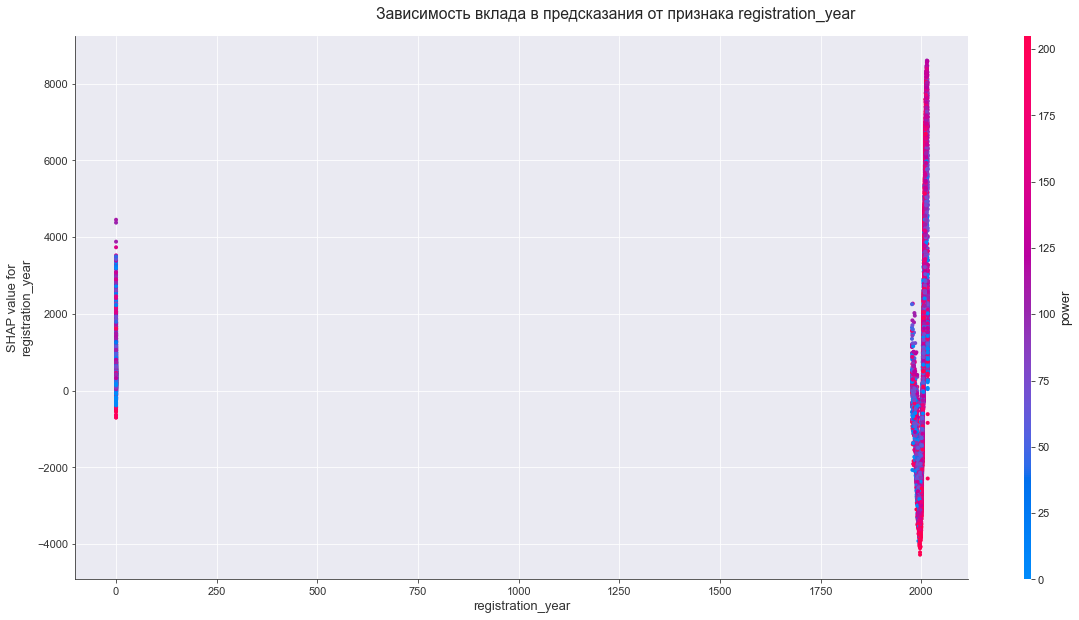

In [151]:
dependence_test('registration_year', xlim = None)

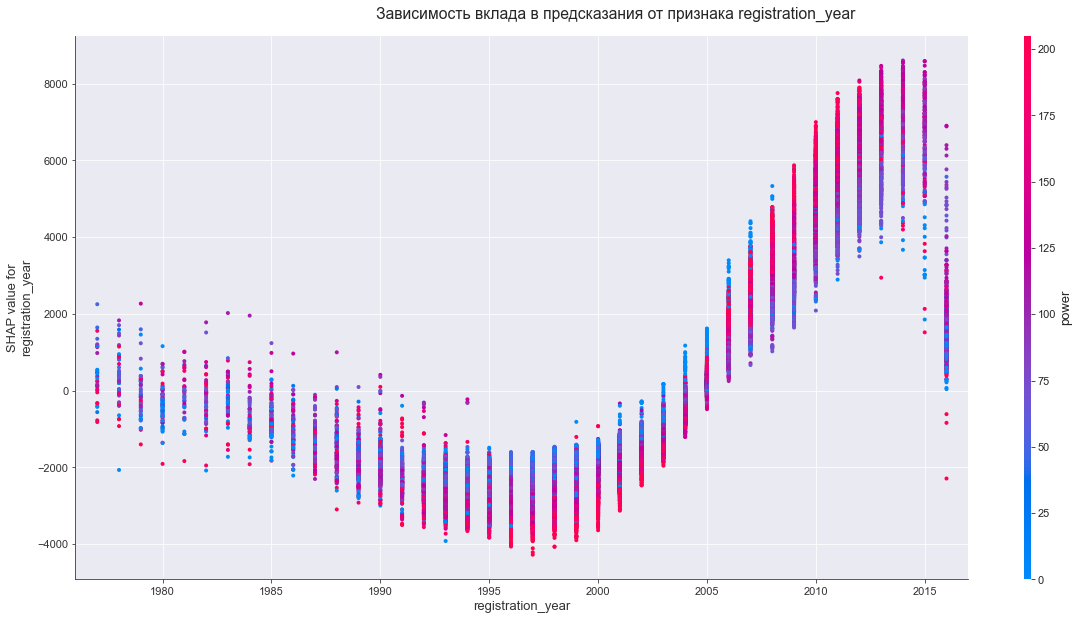

In [152]:
dependence_test('registration_year', xlim = [1976, 2017])

- Пропуски вносят значительный вклад в завышение предсказания.
- Модели с годом выпуска до начала 2000-х больше занижают предсказания, с увеличением года (до начала 2000-х) вклад в занижение увеличивается.
- Модели с годом выпуска новее 2000-ого больше завышают предсказания, с увеличением года вклад в завышение увеличивается.

##### Тип коробки передач

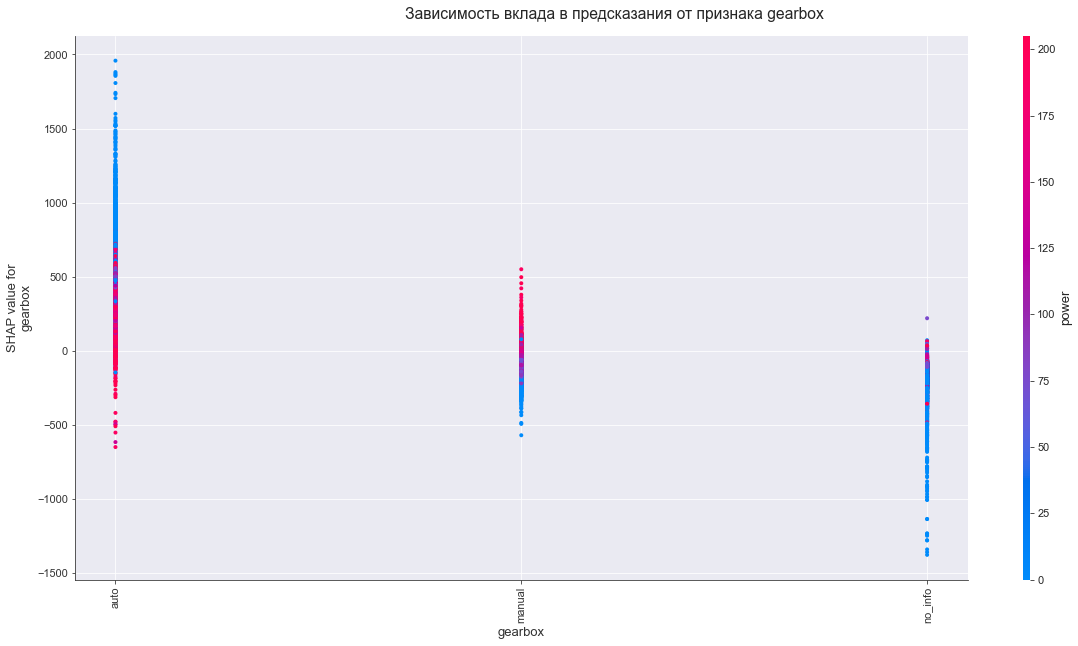

In [153]:
dependence_test('gearbox', xlim = None)

- Автоматическая коробка передач вносит больший вклад в предсказание, в основном увеличивает предсказание.

##### Мощность (л. с.)

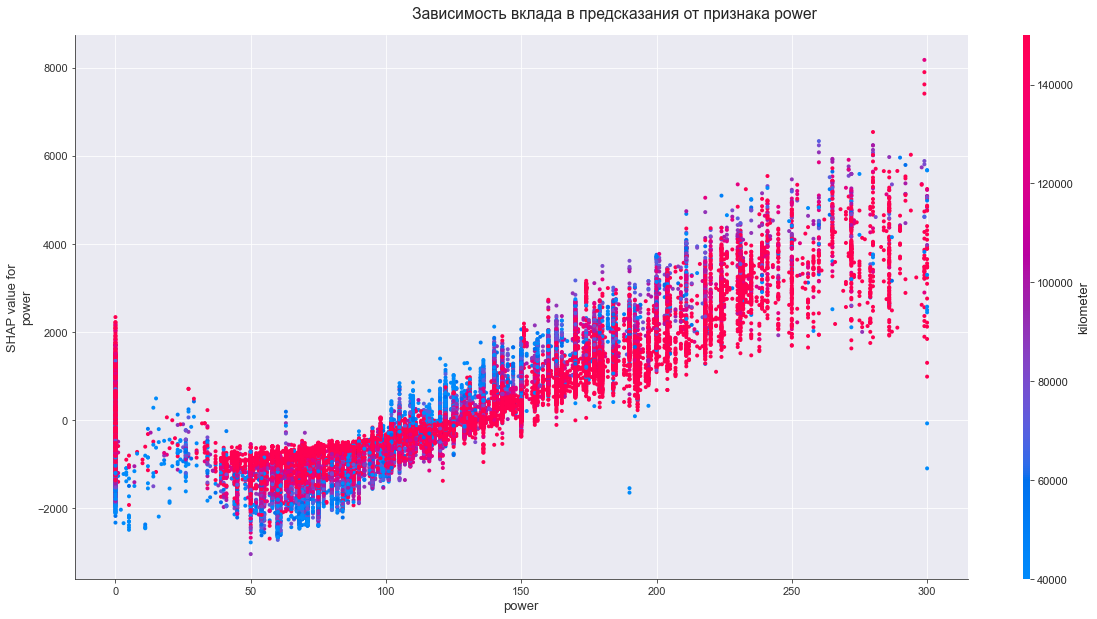

In [154]:
dependence_test('power', xlim = None)

- Пропуски вносят значительный вклад в как в завышение, так и в занижение предсказания.
- При увеличении мощности вклад в предсказание увеличивается.

##### Модель автомобиля

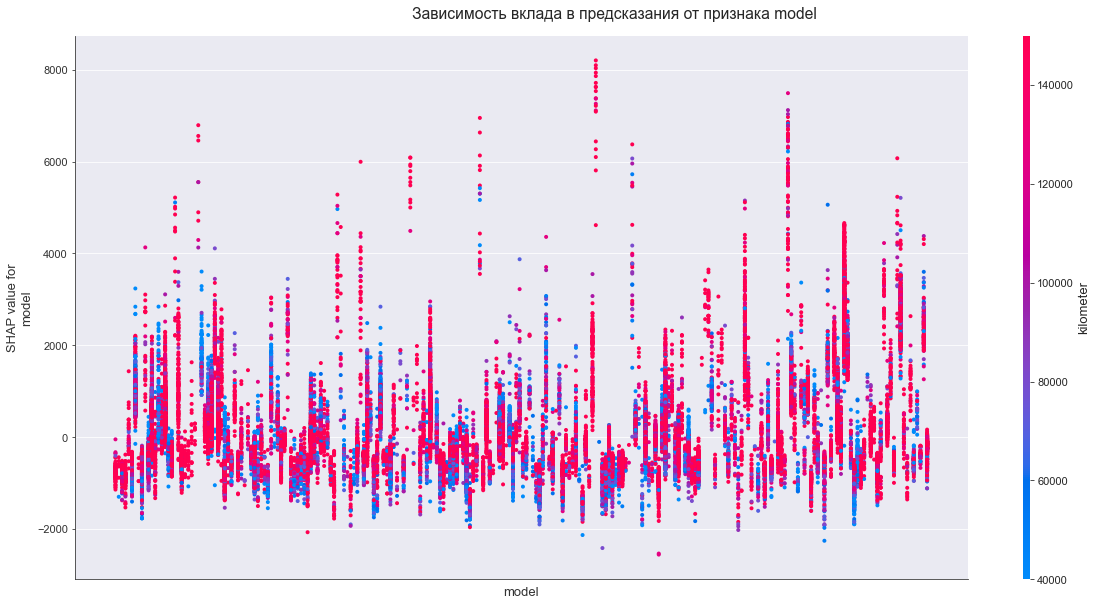

In [155]:
dependence_test('model', xlim = None)

- Модель в равной мере завышает и занижает вклад в предсказание.
- Выделяются модели завышающие вклад больше остальных, скорее всего это дорогие автомобили.

##### Пробег (км)

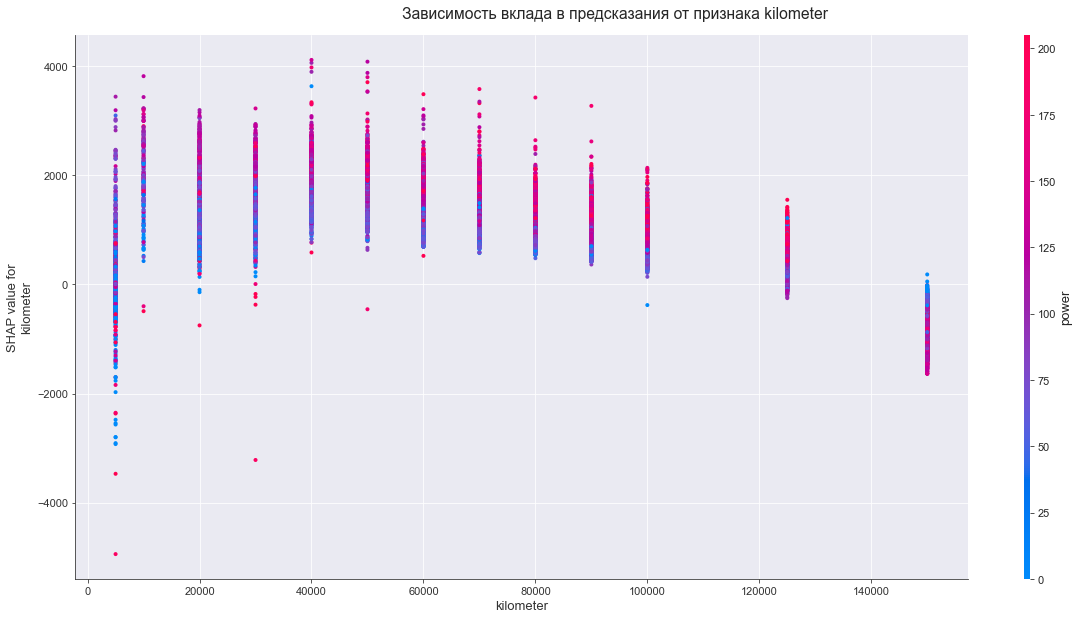

In [156]:
dependence_test('kilometer', xlim = None)

- Автомобили с минимальным пробегом в равной степени завышают и занижают вклад в предсказание. 
- Пробег от 10 000 до 150 000 завышает вклад в предсказание.
- Пробег 150 000 занижает вклад в предсказание.
- Автомобили с пробегом 40 000 - 50 000 максимально завышают вклад в предсказание.

##### Месяц регистрации автомобиля

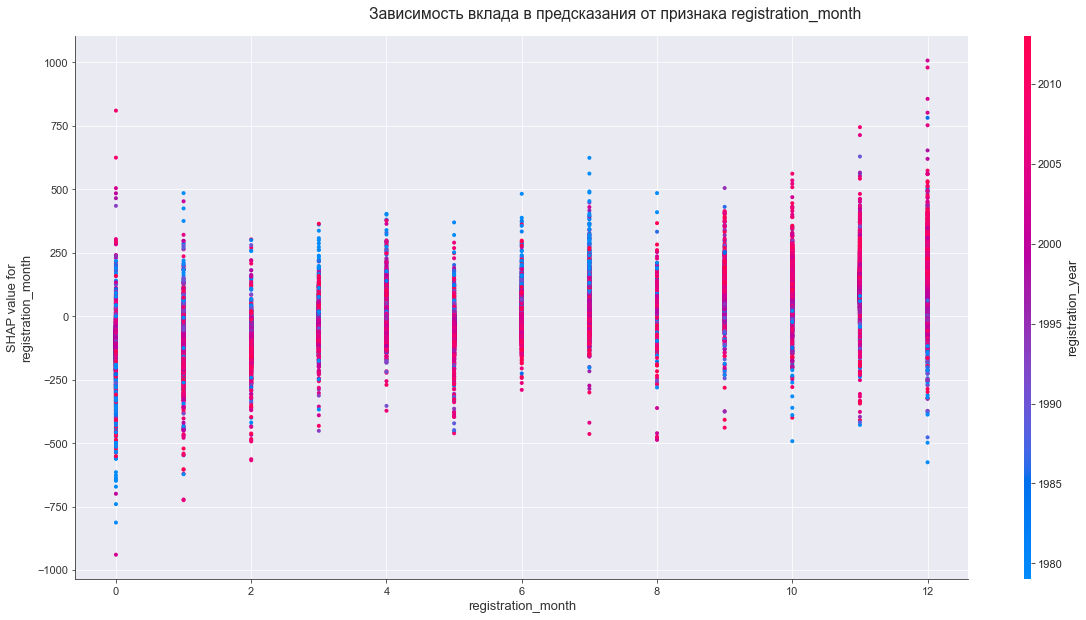

In [157]:
dependence_test('registration_month', xlim = None)

- Пропуски (нулевые значения) влияют на вклад в предсказание, занижая его.
- Месяцы с первого по пятый занижают вклад, с убыванием номер месяца в данном диапазоне вклад становится меньше.
- Месяцы с шестого по восьмой в равной степени увеличивают и уменьшают вклад.
- Месяцы с девятого по двенадцатый больше увеличивают вклад.

##### Тип топлива

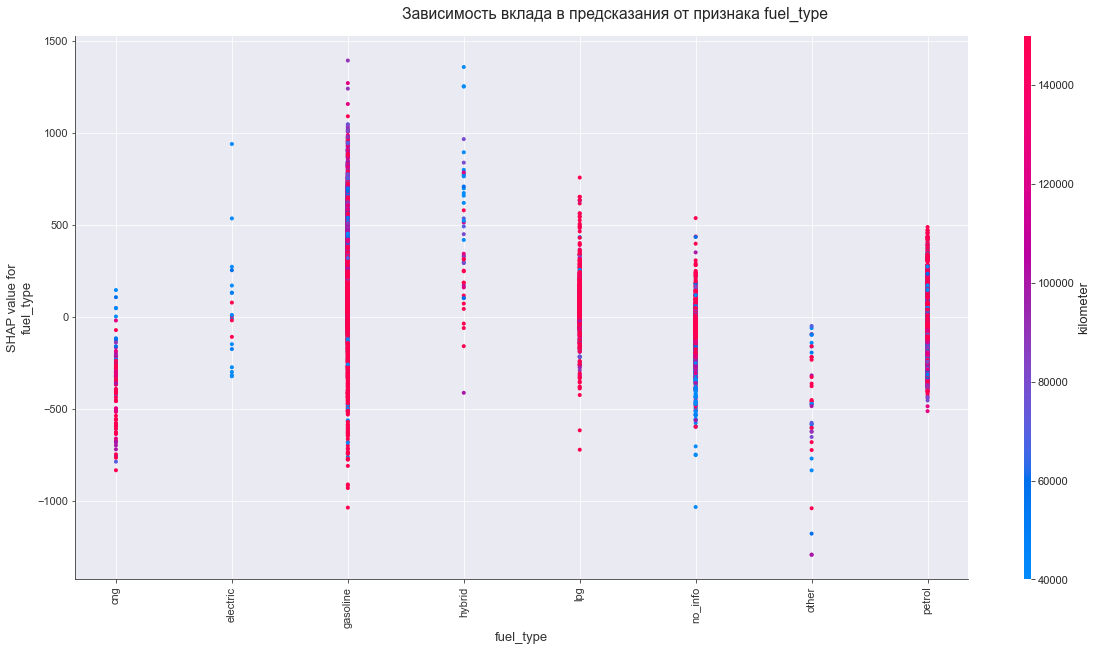

In [158]:
dependence_test('fuel_type', xlim = None)

- тип топлива `gasoline` максимально влияет на вклад в предсказание, как увеличивая, так и уменьшая его.
- Пропуски оказывают значительное влияние на вклад в предсказание, как увеличивая, так и уменьшая его.

##### Марка автомобиля

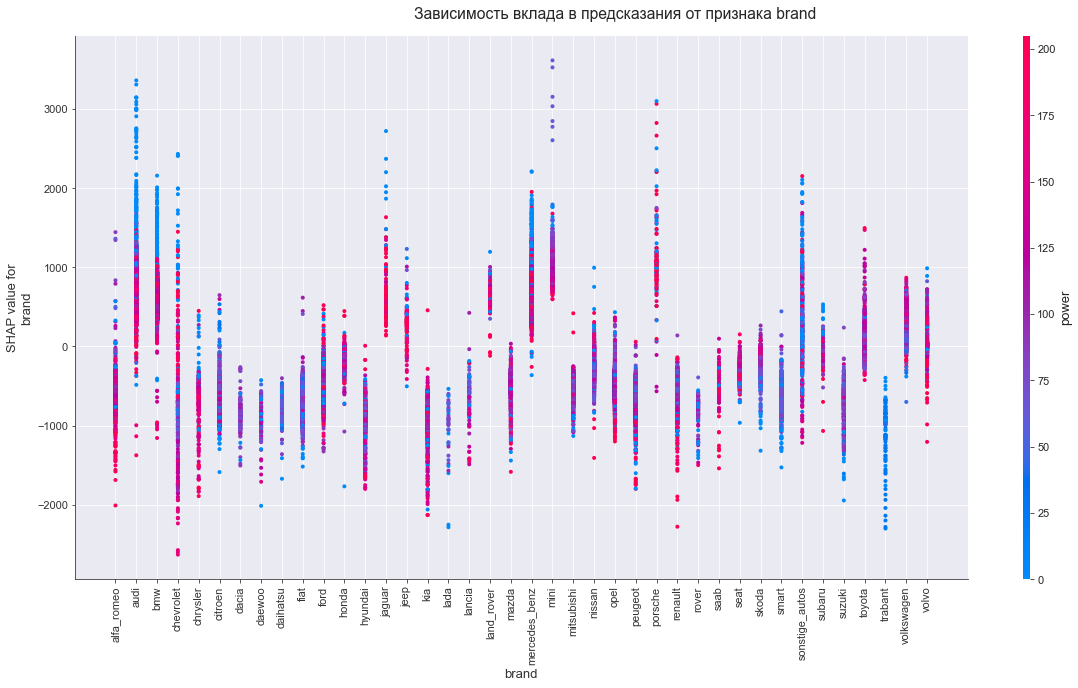

In [159]:
dependence_test('brand', xlim = None)

- Больше всего увеличивает вклад в предсказание марка `audi`.
- Больше всего уменьшает вклад в предсказание марка `chevrolet`.
- Также есть марки с небольшим количеством значений, но сильно влияющим на вклад в предсказание, такие как `trabanat`, `mini`, `jaguar`, `porsche`.

##### Была машина в ремонте или нет

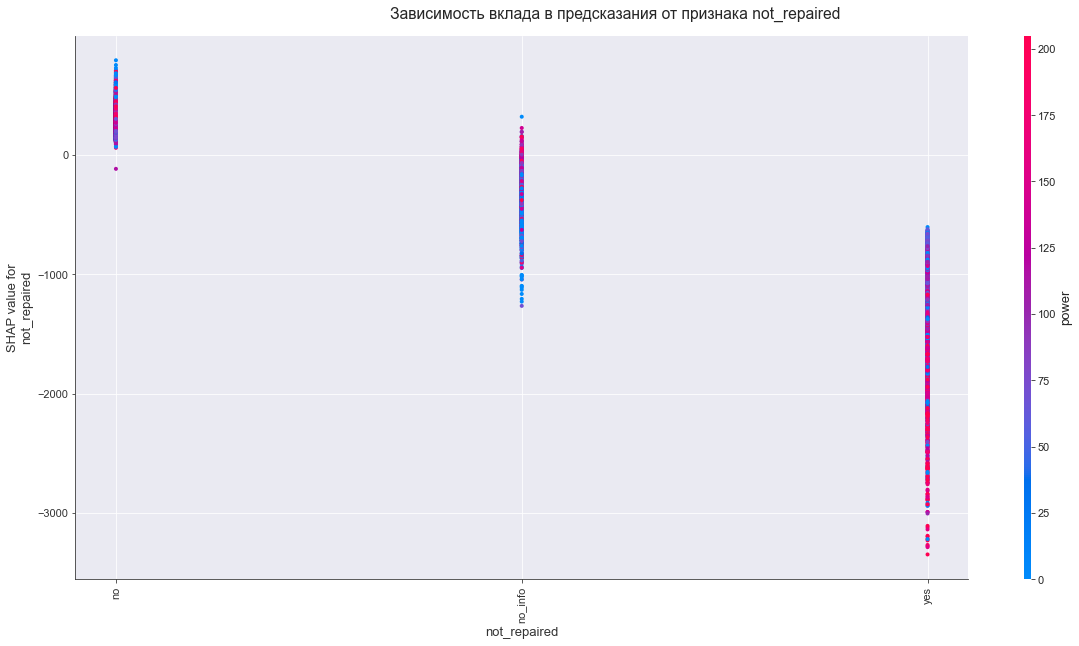

In [160]:
dependence_test('not_repaired', xlim = None)

- Пропуски влияют на вклад в предсказание, уменьшая его.
- Отремонтированные машины сильнее влияют на вклад, уменьшая его.

## Выводы

Для компании «Не бит, не крашен»:
- проведено EDA исследование данных,
- данные обработаны для машинного обучения,
- проведено машинное обучение,
- выбрана лучшая по критериям заказчика модель и проверена на тестовой выборке,
- проведена интерпретация результатов машинного обучения, по результатам которой сделаны выводы для дальнейшего улучшения модели совместно с заказчиком.